# 1. Measurements

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

import constants as C
import metadata as m

4 Measurements
1. ***Robustness***: Measuring how much saliency vectors diverge across different seeds within the same models
2. ***Consensus***: Measuring the consensus between saliency vectors of a fixed model vs other models.
3. ***Alignments***: Measuring how much saliency vectors are aligned with conventional methods. Since occlusion training 
4. ***LightGBM R2***: Performance of saliency vectors on LightGBM Regressor.

In [8]:
df = m.load_robustness()

Load from /home/daehyun/codespace/brain-age-prediction/RQ/assets/full_robustness_250312.csv


In [12]:
all_xai = C.XAI_METHODS + list(C.XAI_METHODS_MAPPER.values())

In [13]:
df = m.load_robustness()
df = df[df["XAI Method"].isin(all_xai)]
df = df.replace(to_replace=C.XAI_METHODS_MAPPER)

# TODO: remove const
df_adni = pd.read_csv("assets/full_robustness_adni_250312.csv")
df_adni = df_adni[df_adni["XAI Method"].isin(all_xai)]
df_adni = df_adni.replace(to_replace=C.XAI_METHODS_MAPPER)

Load from /home/daehyun/codespace/brain-age-prediction/RQ/assets/full_robustness_250312.csv


In [15]:
def get_sims(df: pd.DataFrame, model_name: str):
    _df = df.copy()
    
    c1 = _df.Source.str.startswith(model_name)
    _df.loc[c1, "Model Key"] = _df[c1].Source

    c2 = _df.Target.str.startswith(model_name)
    _df.loc[c2, "Model Key"] = _df[c2].Target
    
    cond = c1 ^ c2
    _df = _df[cond]

    result = _df.groupby(["XAI Method", "Similarity Method"]).agg(
        Similarity=("Similarity", "mean"),
        similarity_std=("Similarity", "std")
    ).reset_index()
    result['Model Key'] = model_name
    return result

In [16]:
def to_square(df: pd.DataFrame, xai_key: str = None, method: str = None) -> pd.DataFrame:
    """Convert dataframe into square form for heatmap plots"""
    if not (xai_key is None and method is None):
        subdf = df[(df[C.XCOL] == xai_key) & (df["Similarity Method"].str.contains(method))]
    else:
        subdf = df.copy()
    subdf = subdf[["Similarity", "Source", "Target"]]

    ids = np.unique(subdf[['Source', 'Target']])
    matrix = pd.DataFrame(data=np.nan, index=ids, columns=ids)
    for _, row in subdf.iterrows():
        matrix.at[row['Source'], row['Target']] = row['Similarity']
        matrix.at[row['Target'], row['Source']] = row['Similarity']  # if the matrix is symmetric
    return matrix


def heatmap(rob: pd.DataFrame, method: str, auto_cbar: bool = True, plot_up: bool = False,
            diagonal: bool = False, vmin: float = -1, cmap: str = "coolwarm",
            suptitle: str = "", save: str = "",
            one_row: bool = False, tick_rotation: int = 0) -> None:
    # assert method in {"spearmanr", "cossim"}, f"Method: {method}"
    if one_row:
        # Create 9 subplots - 8 for heatmaps and 1 narrow one for colorbar
        fig = plt.figure(figsize=(60, 8))
        gs = fig.add_gridspec(1, 10, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 0.05])
        ax = [fig.add_subplot(gs[0, i]) for i in range(len(C.XAI_METHODS))]  # First 8 for plots
        cbar_ax = fig.add_subplot(gs[0, 9])  # Last one for colorbar
    else:
        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
        ax = ax.flatten()  # Convert 2D array to 1D for easier indexing
        
    vmin = None if auto_cbar else vmin
    vmax = None if auto_cbar else 1

    cmap = sns.color_palette(cmap, as_cmap=True)
    cmap.set_bad(color="white")

    for idx, xai in enumerate(C.XAI_METHODS):
        _ax = ax[idx]

        mat = to_square(df=rob, xai_key=C.XAI_METHODS_MAPPER.get(xai, xai), method=method)
        mat = mat.fillna(vmin)
        mask = np.triu(np.ones_like(mat, dtype=bool))
        mask = np.hstack([np.vstack(
            [np.ones_like(np.eye(10)) if i >= j else np.zeros_like(np.eye(10)) for j in range(9)])
        for i in range(9)]).astype(bool)
        
        if one_row:
            # Draw heatmap with colorbar for each subplot
            sns.heatmap(mat, mask=None if plot_up else mask, cmap=cmap, ax=_ax, vmin=vmin, vmax=vmax,
                       square=True, linewidth=0., cbar=False)
            # Plotting colorbars
            if idx == len(C.XAI_METHODS) - 1:
                # Create a separate colorbar in the narrow subplot
                norm = plt.Normalize(vmin=vmin if vmin is not None else mat.min().min(),
                                     vmax=vmax if vmax is not None else mat.max().max())
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                # Create thin vertical colorbar with reduced height
                cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
                # Adjust position to make colorbar shorter while keeping width
                pos = cbar_ax.get_position()
                height_reduction = 0.4  # Reduce height by 40%
                new_height = pos.height * (1 - height_reduction)
                y_offset = pos.height * (height_reduction / 2)  # Center the shorter colorbar
                cbar_ax.set_position([pos.x0, 
                                    pos.y0 + y_offset,  # Move up to center
                                    0.01,  # Width of colorbar - keep it thin
                                    new_height])  # Reduced height
        else:
            heatmap_kwargs = {'cbar_kws': {'shrink': 0.5}}
            sns.heatmap(mat, mask=None if plot_up else mask, cmap=cmap, ax=_ax, vmin=vmin, vmax=vmax,
                       square=True, linewidth=0., **heatmap_kwargs)
            
        _ax.set_title(C.XAI_METHODS_MAPPER.get(xai, xai), size="x-large")
        _ax.grid(False)
        
        tick_interval = len(C.SEEDS)
        matrix_size = tick_interval * len(C.MODELS)
        
        line_kwgs = dict(color='k', linewidth=1.2)
        for i in range(tick_interval, matrix_size, tick_interval):
            if diagonal:
                _ax.axvline(i,  (1 - (i - tick_interval) / matrix_size), (1 - ((i + tick_interval) / matrix_size)), **line_kwgs)  # 세로선
                _ax.axhline(i,  ((i - tick_interval) / matrix_size), (i + tick_interval) / matrix_size, **line_kwgs)  # 가로선
            else:
                _ax.axvline(i, 0, (1 - (i / matrix_size)), **line_kwgs)  # 세로선
                _ax.axhline(i, 0, i / matrix_size, **line_kwgs)  # 가로선

        _ax.set_xticks(
            ticks=np.arange(0, matrix_size, tick_interval) + 5,
            labels=C.MODEL_KEY.values(), rotation=90 - tick_rotation  # 레이블 회전
        )
        
        if one_row:
            # Only show yticks for the first plot
            if idx == 0:
                _ax.set_yticks(
                    ticks=np.arange(0, matrix_size, tick_interval) + 5,
                    labels=C.MODEL_KEY.values(), rotation=tick_rotation  # 레이블 회전
                )
            else:
                _ax.set_yticks([])
        else:
            _ax.set_yticks(
                ticks=np.arange(0, matrix_size, tick_interval) + 5,
                labels=C.MODEL_KEY.values(), rotation=tick_rotation  # 레이블 회전
            )

    if save:
        fig.tight_layout()
        fig.savefig(save, dpi=150, bbox_inches="tight")
    else:
        fig.suptitle(suptitle, size="xx-large")
        fig.tight_layout()

In [17]:
title_size = 40
rowlabel_size = 40
ticksize = 22

def heatmap2(rob1: pd.DataFrame, rob2: pd.DataFrame, method: str, auto_cbar: bool = True,
            plot_up: bool = False, diagonal: bool = False, vmin: float = -1, cmap: str = "coolwarm",
            suptitle: str = "", save: str = "", tick_rotation: int = 0) -> None:
    
    # Create a figure with 2 rows (for rob1 and rob2) and 10 columns (9 for plots, 1 for colorbar)
    fig = plt.figure(figsize=(60, 16))  # 더 커진 figure 크기
    gs = fig.add_gridspec(2, 10, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 0.05])  # 2 rows
    
    ax = [[fig.add_subplot(gs[i, j]) for j in range(len(C.XAI_METHODS))] for i in range(2)]  # 2 rows
    cbar_ax = fig.add_subplot(gs[:, 9])  # 두 row가 공유하는 colorbar

    vmin = None if auto_cbar else vmin
    vmax = None if auto_cbar else 1

    cmap = sns.color_palette(cmap, as_cmap=True)
    cmap.set_bad(color="white")

    for row_idx, rob in enumerate([rob1, rob2]):  # row_idx=0 (rob1), row_idx=1 (rob2)
        for col_idx, xai in enumerate(C.XAI_METHODS):
            _ax = ax[row_idx][col_idx]

            mat = to_square(df=rob, xai_key=C.XAI_METHODS_MAPPER.get(xai, xai), method=method)
            mask = np.hstack([np.vstack(
                [np.ones_like(np.eye(10)) if i >= j else np.zeros_like(np.eye(10)) for j in range(9)])
            for i in range(9)]).astype(bool)

            if plot_up:
                mask = (~mask + ~mask.T)
                mat = mat.fillna(vmin)
            else:
                mat = mat.fillna(vmin)

            # Heatmap 그리기
            sns.heatmap(mat, mask=mask, cmap=cmap,
                        ax=_ax, vmin=vmin, vmax=vmax,
                        square=True, linewidth=0., cbar=False)
            
            if row_idx == 0:  # 첫 번째 row (rob1)에서만 타이틀 추가
                _ax.set_title(C.XAI_METHODS_MAPPER.get(xai, xai), size=title_size)

            _ax.grid(False)
            
            tick_interval = len(C.SEEDS)
            matrix_size = tick_interval * len(C.MODELS)

            line_kwgs = dict(color='k', linewidth=1.1)
            for i in range(tick_interval, matrix_size, tick_interval):
                if diagonal:
                    _ax.axvline(i, (1 - (i - tick_interval) / matrix_size), (1 - ((i + tick_interval) / matrix_size)), **line_kwgs)
                    _ax.axhline(i, ((i - tick_interval) / matrix_size), (i + tick_interval) / matrix_size, **line_kwgs)
                else:
                    _ax.axvline(i, 0, (1 - (i / matrix_size)), **line_kwgs)
                    _ax.axhline(i, 0, i / matrix_size, **line_kwgs)

            _ax.set_xticks(
                ticks=np.arange(0, matrix_size, tick_interval) + 5,
                labels=C.MODEL_KEY.values(), rotation=90 - tick_rotation
            )
            if row_idx == 1:  # 두 번째 row에서만 xticks 표시
                _ax.set_xticklabels(C.MODEL_KEY.values(), rotation=90 - tick_rotation, size=ticksize)
            else:
                _ax.set_xticklabels([])  # 첫 번째 row는 xticks 제거
                _ax.set_xlabel("")
            
            if col_idx == 0:  # 각 row의 첫 번째 subplot에만 ytick 추가
                _ax.set_yticks(
                    ticks=np.arange(0, matrix_size, tick_interval) + 5,
                    labels=C.MODEL_KEY.values(), rotation=tick_rotation, size=ticksize
                )
                _ax.set_ylabel(["UKBiobank", "ADNI"][row_idx], fontsize=rowlabel_size, labelpad=30)  # 큰 label 추가

            else:
                _ax.set_yticks([])

    # Colorbar 설정 (두 row가 공유)
    norm = plt.Normalize(vmin=vmin if vmin is not None else min(rob1.min().min(), rob2.min().min()),
                         vmax=vmax if vmax is not None else max(rob1.max().max(), rob2.max().max()))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')

    if save:
        fig.tight_layout()
        fig.savefig(save, dpi=100, format="pdf", bbox_inches="tight")
    else:
        fig.suptitle(suptitle, size="xx-large")
        fig.tight_layout()

In [18]:
def boxplot(data: pd.DataFrame, order: list = None, hue_order: list = None, plot_type: str = "box",
            x_col: str = C.XCOL, y_col: str = C.YCOL, hue_col: str = C.HUECOL,
            xlabel: str = "Interpretability Methods", ylabel: str = "Consensus (-1 to 1)",
            legend_loc: str = "", palette=None,
            draw_zerobase: bool = True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 4))
    else:
        fig = None
    if draw_zerobase:
        ax.axhline(0, color="gray", linewidth=2)
    if order is None:
        order = list(C.XAI_METHODS_MAPPER.values()) if x_col == C.XCOL else None
    flierprops = dict(marker='o', markerfacecolor="gray", markersize=5,
                      markeredgecolor='white', markeredgewidth=.2, alpha=0.2)
    if plot_type == "box":
        sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, gap=0.1, palette=palette,
                    order=order, hue_order=hue_order, flierprops=flierprops)
    elif plot_type == "violin":
        sns.violinplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, palette=palette,
                    order=order, hue_order=hue_order)
    elif plot_type == "strip":
        sns.stripplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, palette=palette,
                    order=order, hue_order=hue_order, dodge=True)
        sns.pointplot(
            data=data, x=x_col, y=y_col, hue=hue_col, ax=ax,
            dodge=True, palette="dark", errorbar=None,
            markers="d", markersize=4, linestyle="none",
        )

    ax.set_xlabel(xlabel, size="large")
    ax.set_ylabel(ylabel, size="large")
    if legend_loc:
        sns.move_legend(obj=ax, loc=legend_loc)
    return fig

In [19]:
methods_inter = [m for m in df[C.HUECOL].unique().tolist() if m.startswith("Inter")]
methods_intra = [m for m in df[C.HUECOL].unique().tolist() if m.startswith("Intra")]

def parse_method(s: str):
    s = s.split(": ")[-1]
    return s

## 1. Consensus

In [20]:
# Get Consensus Dataframe
# Should be average values over per seeds so that the primary key goes as -
# GradXInput - L2 - resnet10-0

# Sanity checking code
# robustness[(robustness["Model Key"] == "densenet169") & (robustness["Similarity Method"] == "L2") & (robustness["XAI Method"] == "GradXInput")]
con = df[df[C.HUECOL].isin(methods_inter)].copy()
con[C.HUECOL] = con[C.HUECOL].apply(parse_method)

con_adni = df_adni[df_adni[C.HUECOL].isin(methods_inter)].copy()
con_adni[C.HUECOL] = con_adni[C.HUECOL].apply(parse_method)

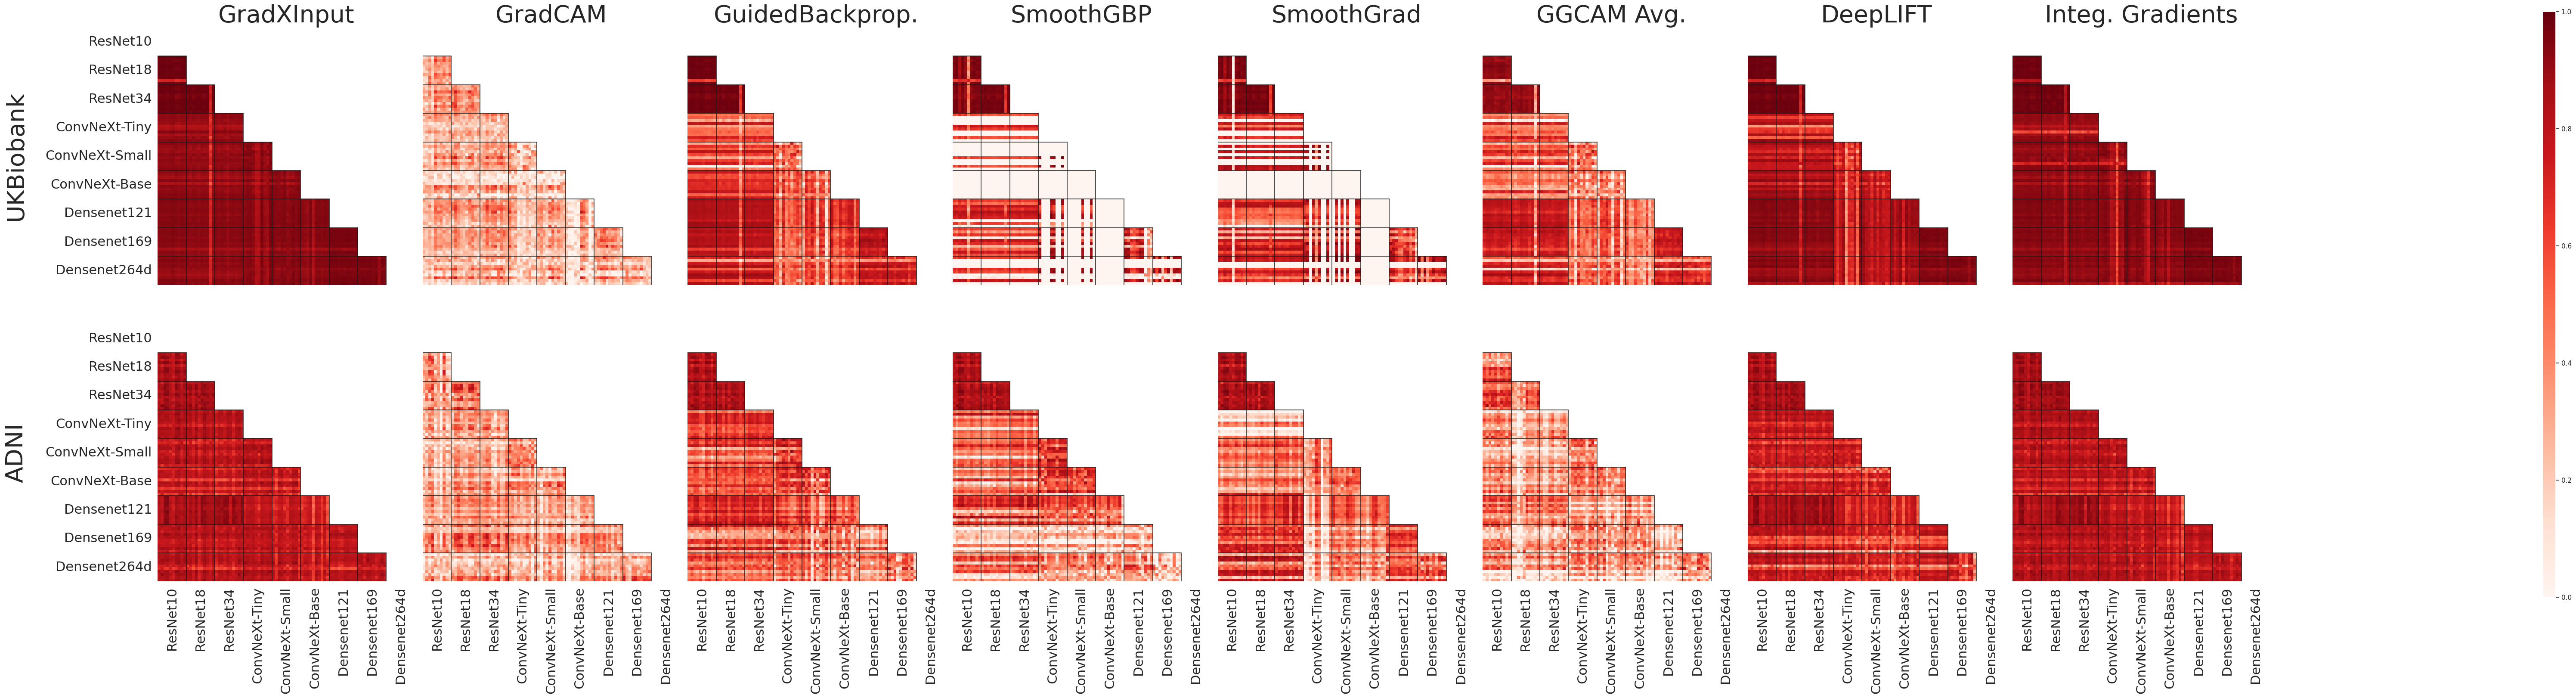

In [9]:
heatmap2(rob1=con, rob2=con_adni, method='SpearmanR', auto_cbar=False, vmin=0, cmap="Reds", save="consensus.pdf")

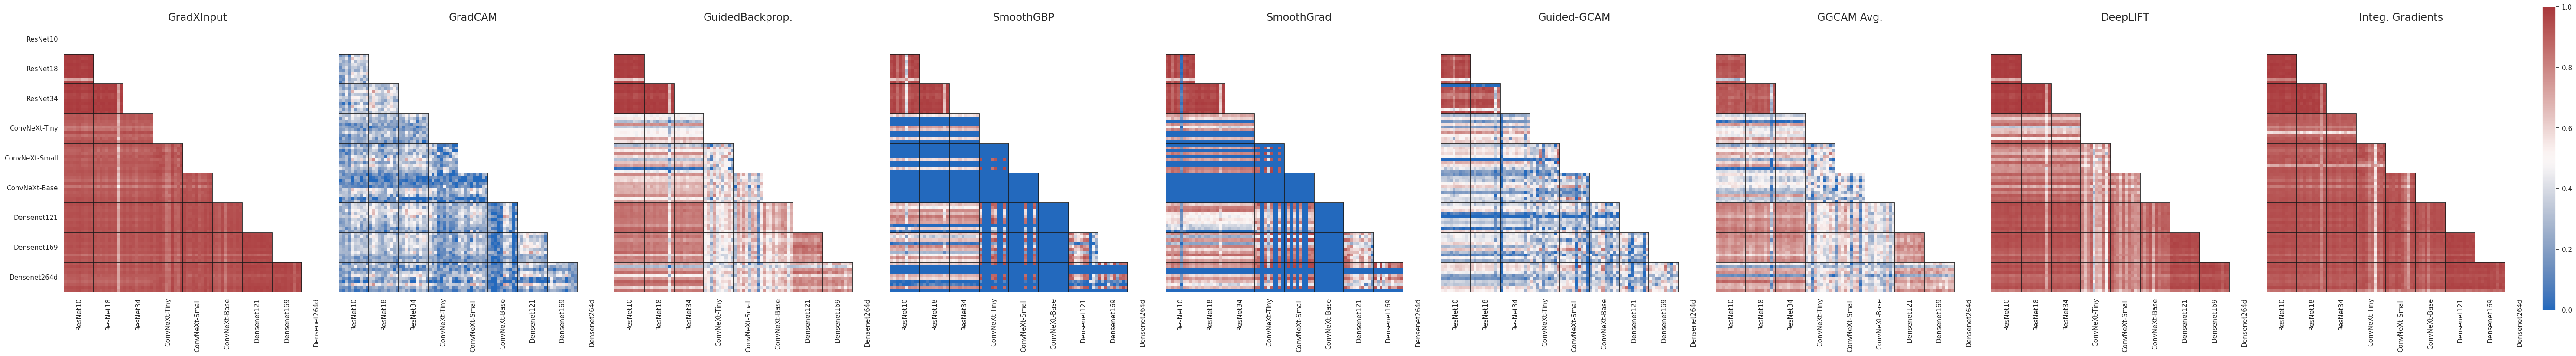

In [137]:
heatmap(rob=con, method='SpearmanR', auto_cbar=False, vmin=0, one_row=True, cmap="vlag")

heatmap(rob=con, method='RBF', auto_cbar=False, vmin=0)

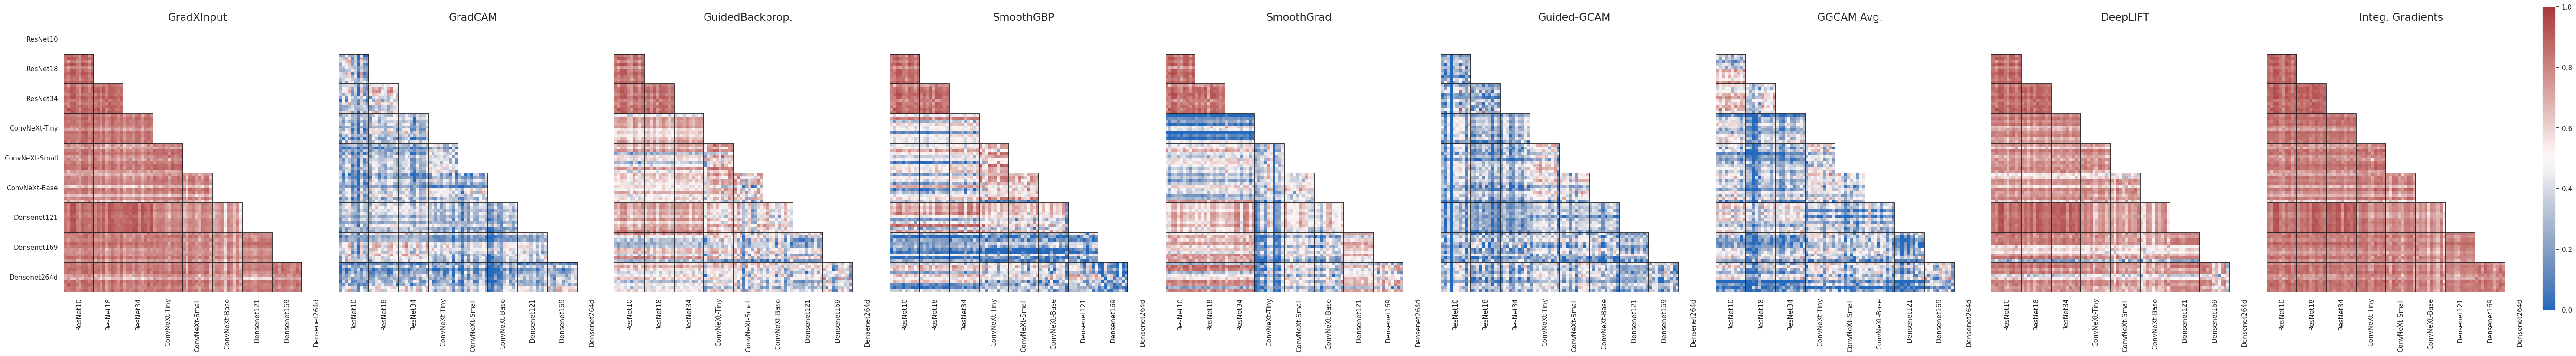

In [138]:
heatmap(rob=con_adni, method='SpearmanR', auto_cbar=False, vmin=0, one_row=True, cmap="vlag")

heatmap(rob=con_adni, method='RBF', auto_cbar=False, vmin=0)

In [21]:
consensus = pd.concat([get_sims(df=con, model_name=model_name)
                        for model_name in set(con.Source.unique()) | set(con.Target.unique())]).reset_index(drop=True)
consensus["Model Arch"] = consensus["Model Key"].apply(lambda m: "-".join(m.split("-")[:-1]))

consensus_adni = pd.concat([get_sims(df=con_adni, model_name=model_name)
                        for model_name in set(con_adni.Source.unique()) | set(con_adni.Target.unique())]).reset_index(drop=True)
consensus_adni["Model Arch"] = consensus_adni["Model Key"].apply(lambda m: "-".join(m.split("-")[:-1]))

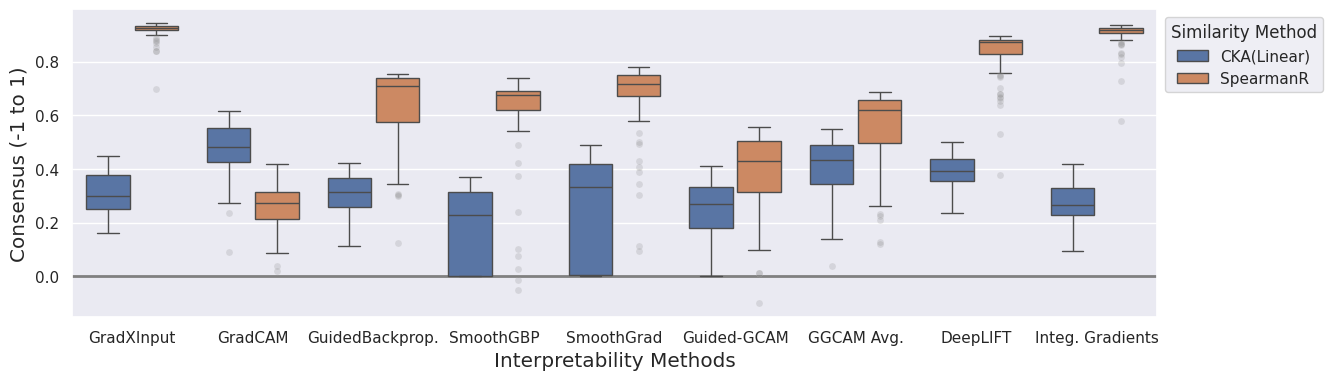

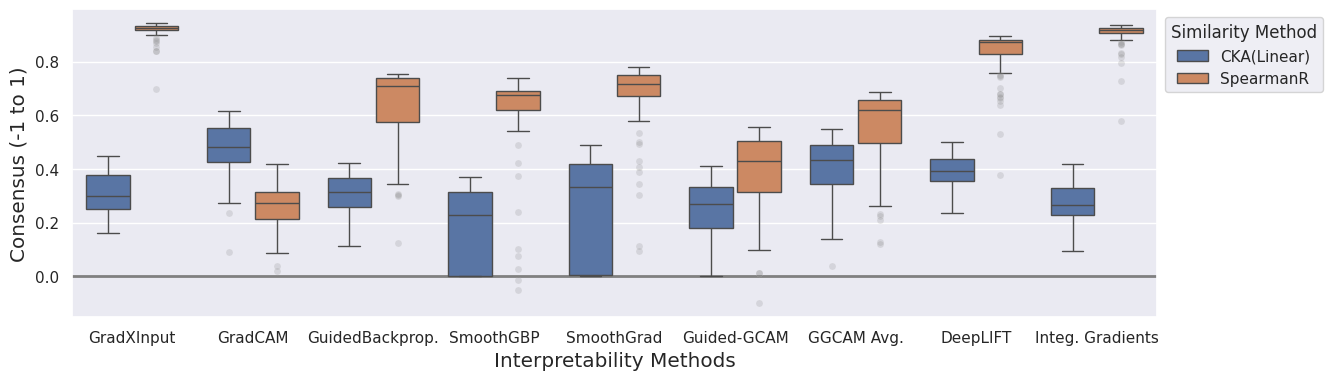

In [140]:
# 모델-seed 단위로 average 때린거
boxplot(data=consensus, ylabel="Consensus (-1 to 1)")

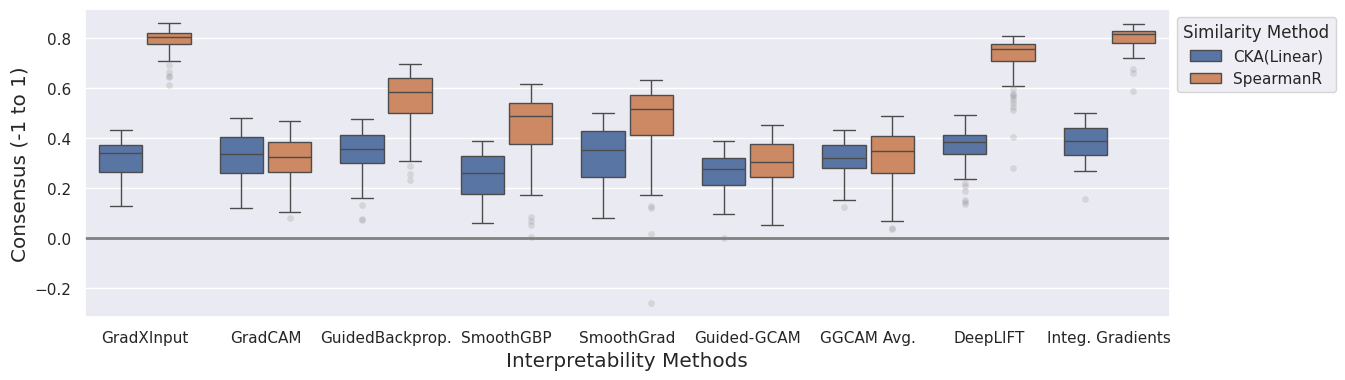

In [12]:
# 모델-seed 단위로 average 때린거
boxplot(data=consensus_adni, ylabel="Consensus (-1 to 1)")

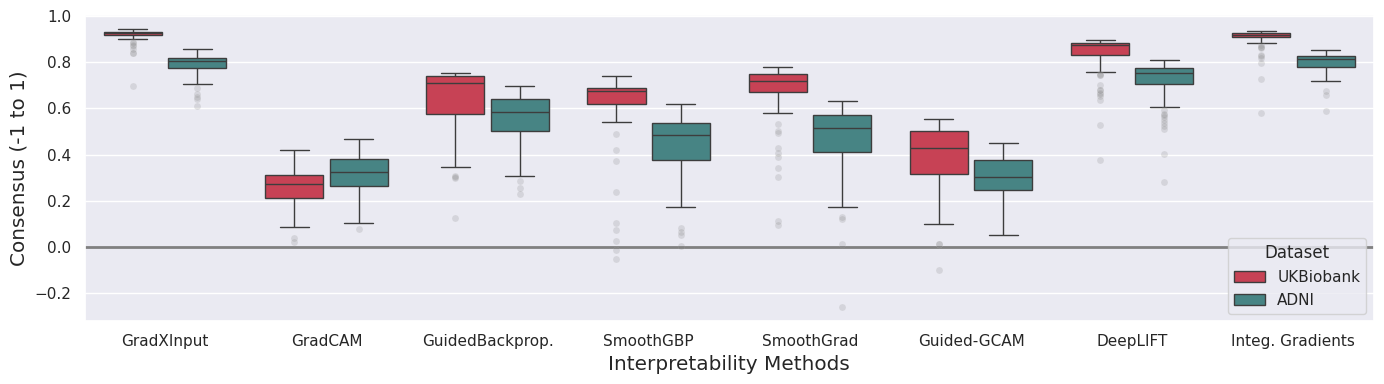

In [22]:
consensus["Dataset"] = "UKBiobank"
consensus_adni["Dataset"] = "ADNI"
con_all = pd.concat([consensus, consensus_adni])
con_all = con_all[con_all["Similarity Method"].isin(["SpearmanR"])].reset_index(drop=True)
fig = boxplot(data=con_all, ylabel="Consensus (-1 to 1)", hue_col="Dataset", legend_loc="lower right",
              palette=[C.ukb_cmap[3], C.adni_cmap[3]])
fig.tight_layout()
fig.savefig("consensus_box.pdf", format="pdf", dpi=100)

## 2. Robustness

In [23]:
# Get Robustness Dataframe
# Should be average values over per seeds so that the primary key goes as -
# GradXInput - L2 - resnet10-0

# Sanity checking code
# robustness[(robustness["Model Key"] == "densenet169") & (robustness["Similarity Method"] == "L2") & (robustness["XAI Method"] == "GradXInput")]
rob = df[df[C.HUECOL].isin(methods_intra)].copy()
rob[C.HUECOL] = rob[C.HUECOL].apply(parse_method)

rob_adni = df_adni[df_adni[C.HUECOL].isin(methods_intra)].copy()
rob_adni[C.HUECOL] = rob_adni[C.HUECOL].apply(parse_method)

In [24]:
robustness = pd.concat([get_sims(df=rob, model_name=model_name)
                        for model_name in set(rob.Source.unique()) | set(rob.Target.unique())]).reset_index(drop=True)
robustness["Model Arch"] = robustness["Model Key"].apply(lambda m: "-".join(m.split("-")[:-1]))

robustness_adni = pd.concat([get_sims(df=rob_adni, model_name=model_name)
                        for model_name in set(rob_adni.Source.unique()) | set(rob_adni.Target.unique())]).reset_index(drop=True)
robustness_adni["Model Arch"] = robustness_adni["Model Key"].apply(lambda m: "-".join(m.split("-")[:-1]))

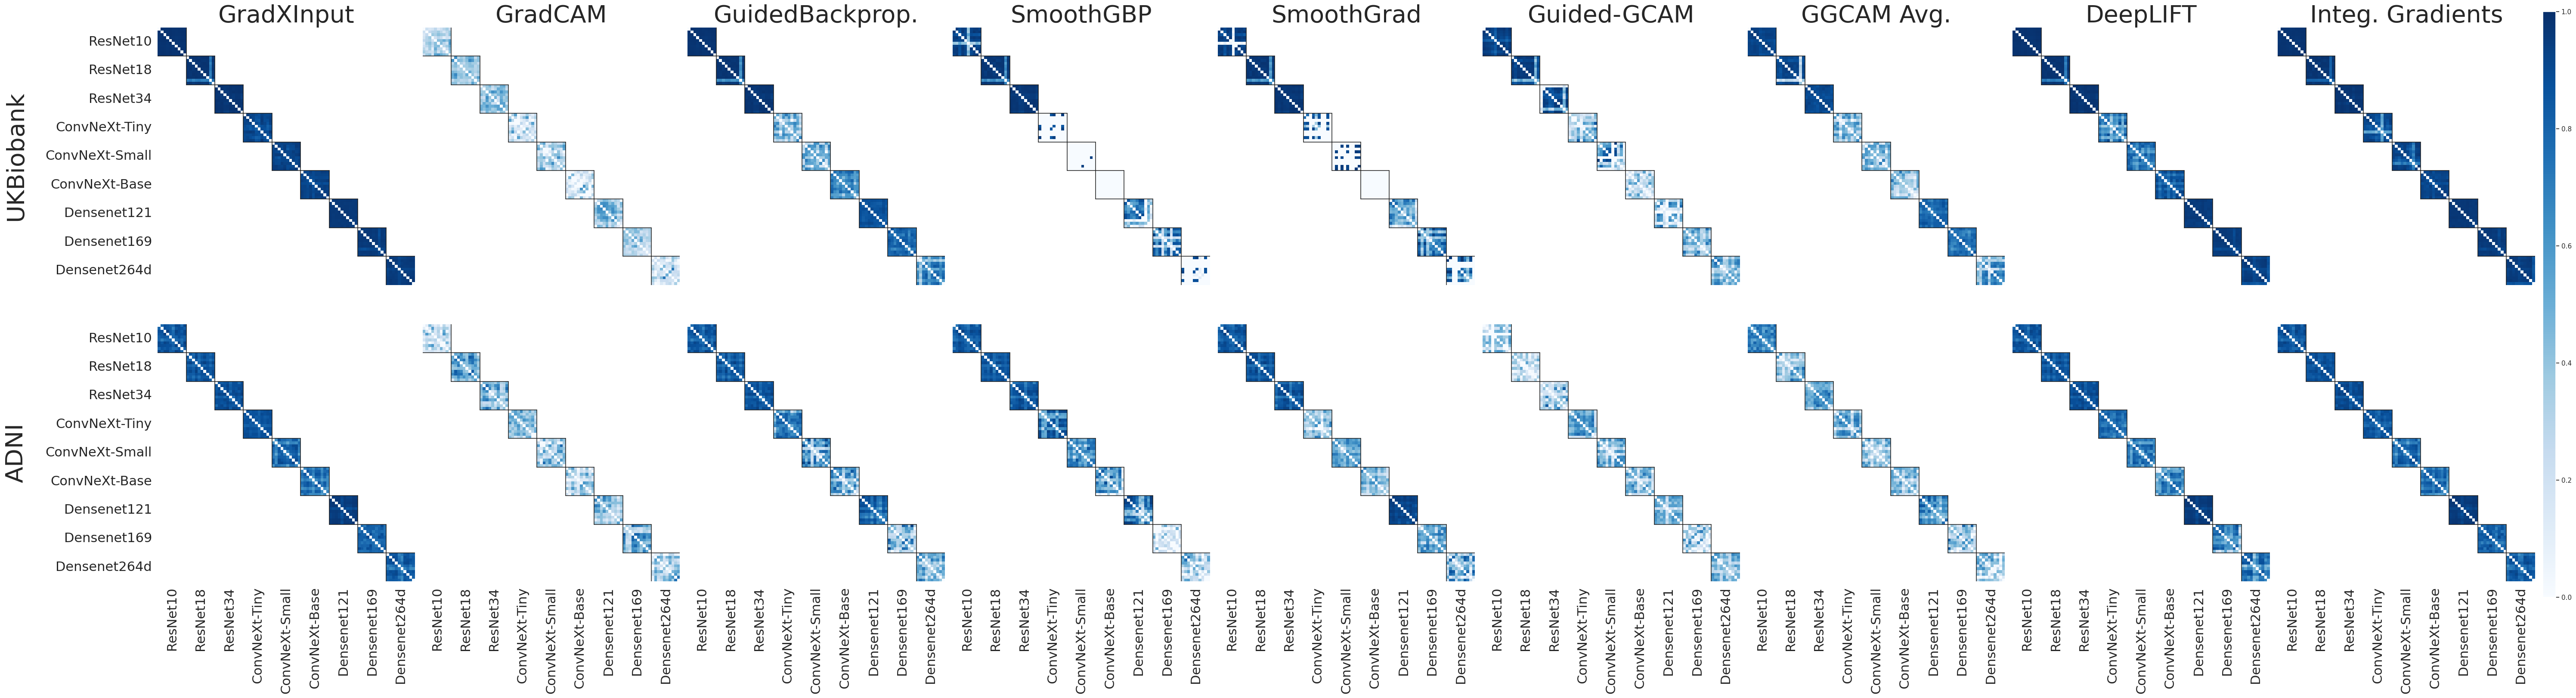

In [129]:
heatmap2(rob1=rob, rob2=rob_adni, method='SpearmanR', auto_cbar=False, diagonal=True, vmin=0,
         plot_up=True, cmap="Blues", save="robustness.pdf")

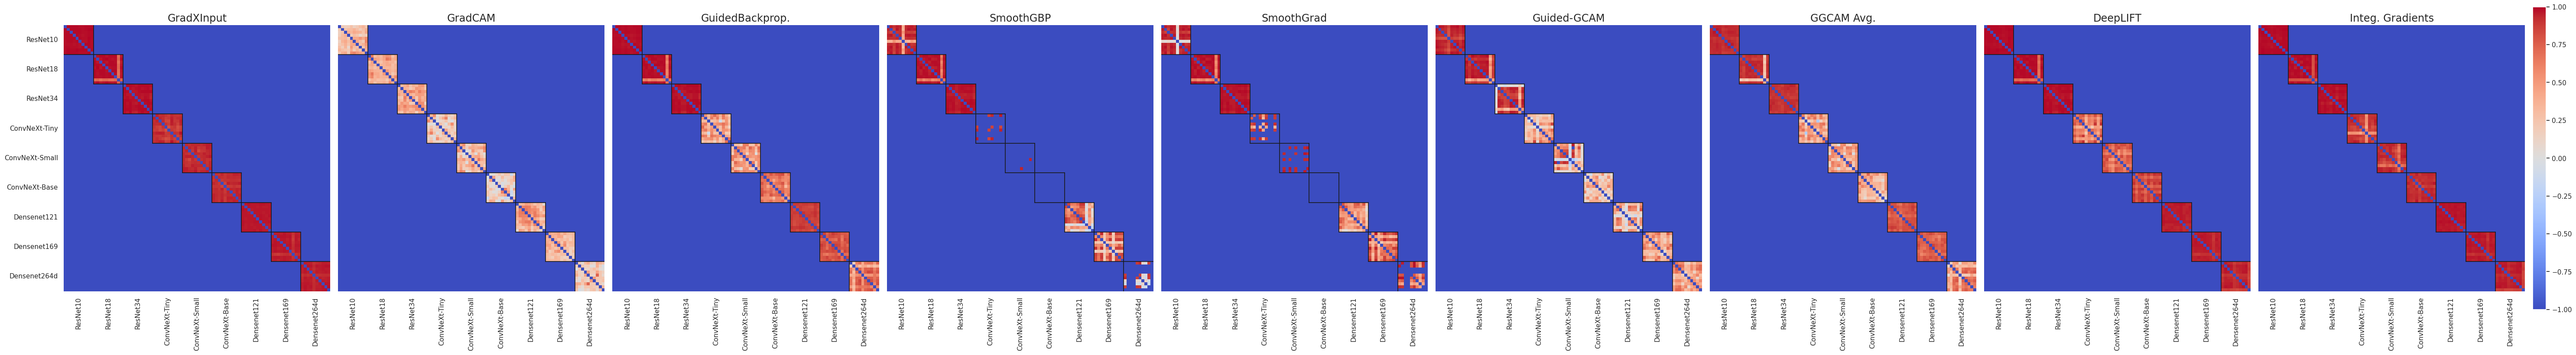

In [85]:
heatmap(rob=rob, method='SpearmanR', plot_up=True, auto_cbar=False, diagonal=True, one_row=True)

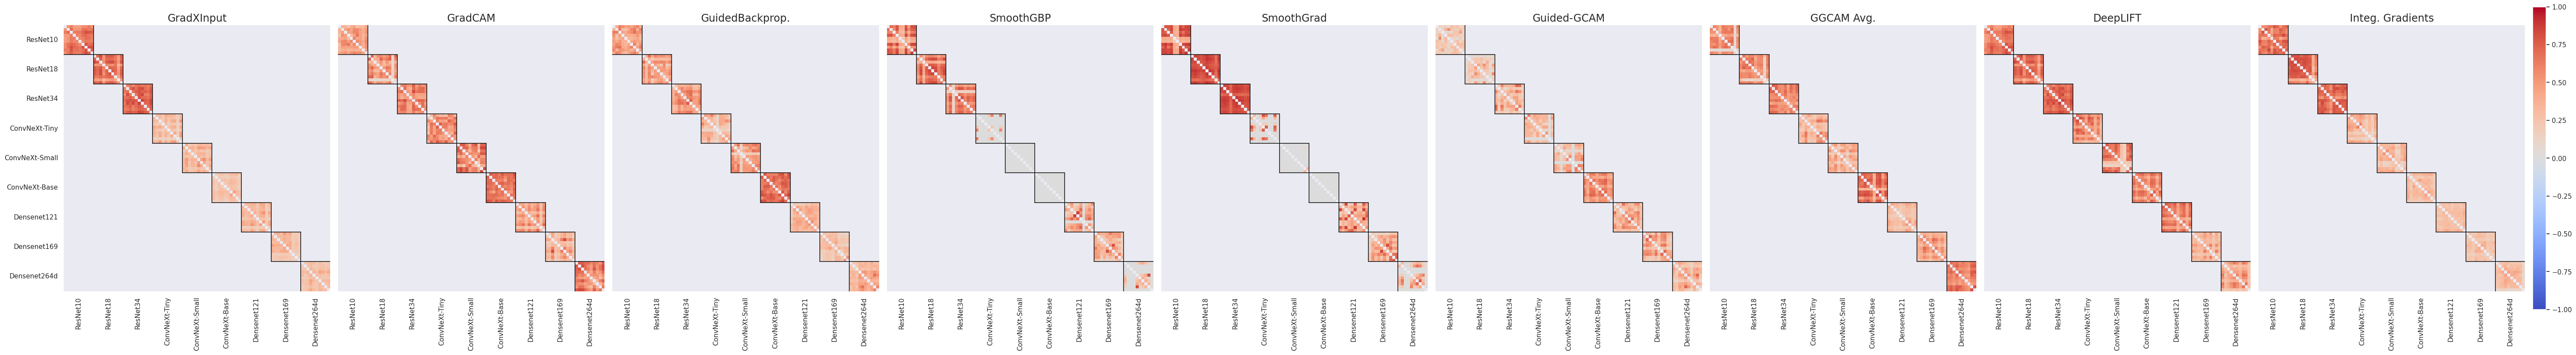

In [17]:
heatmap(rob=rob, method='Linear', plot_up=True, auto_cbar=False, diagonal=True, one_row=True)

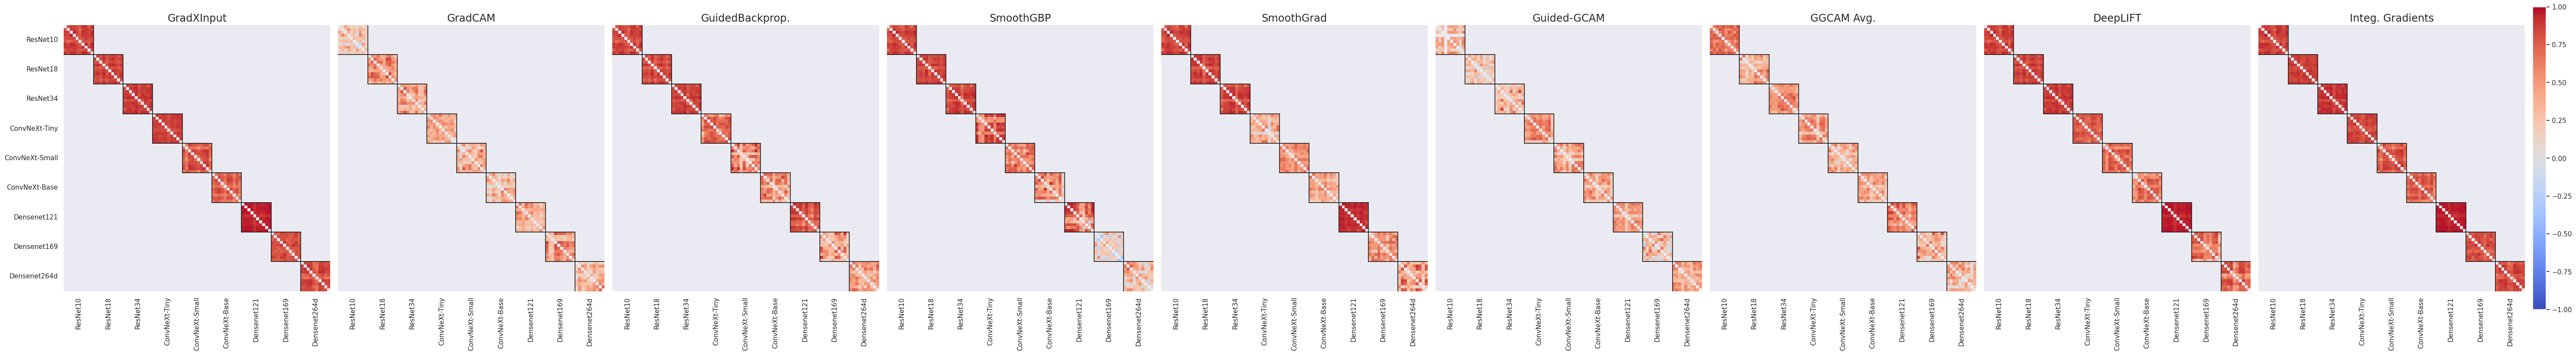

In [18]:
heatmap(rob=rob_adni, method='SpearmanR', plot_up=True, auto_cbar=False, diagonal=True, one_row=True)

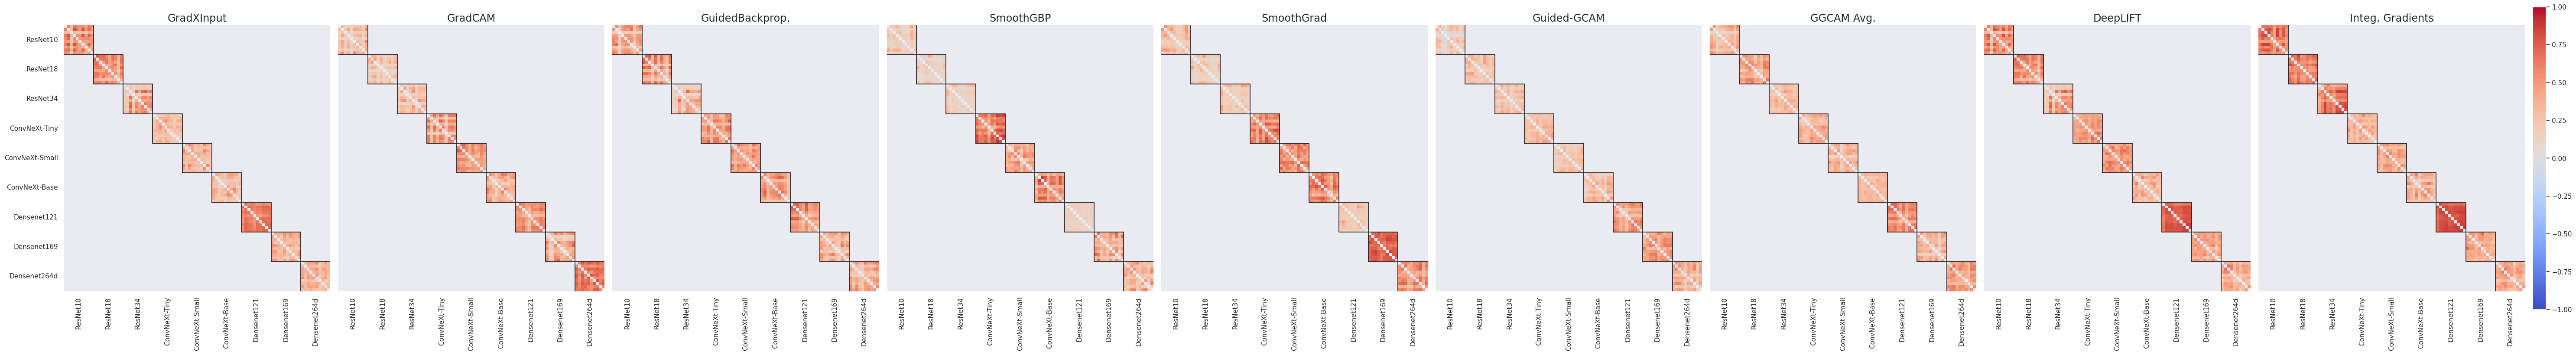

In [19]:
heatmap(rob=rob_adni, method='Linear', plot_up=True, auto_cbar=False, diagonal=True, one_row=True)

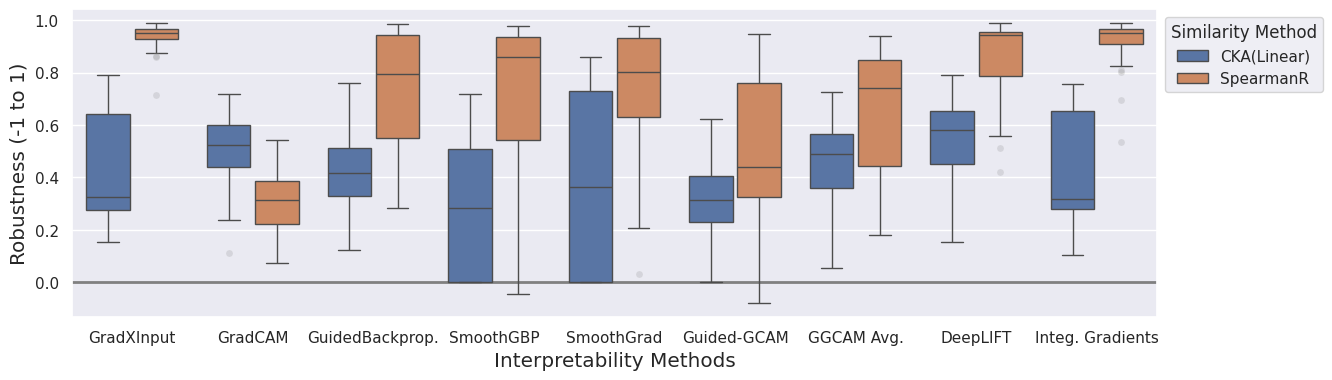

In [20]:
# 모델-seed 단위로 average 때린거
boxplot(data=robustness, ylabel="Robustness (-1 to 1)")

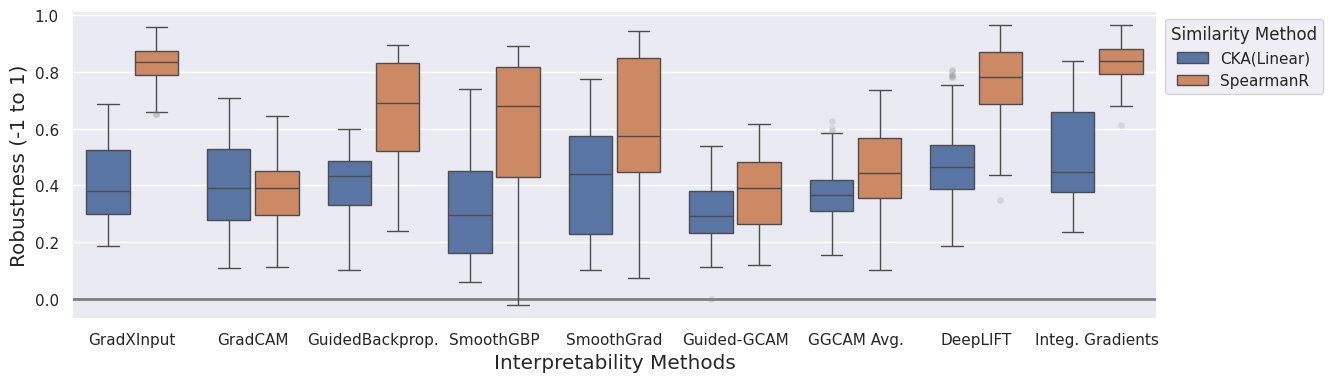

In [21]:
# 모델-seed 단위로 average 때린거
boxplot(data=robustness_adni, ylabel="Robustness (-1 to 1)")

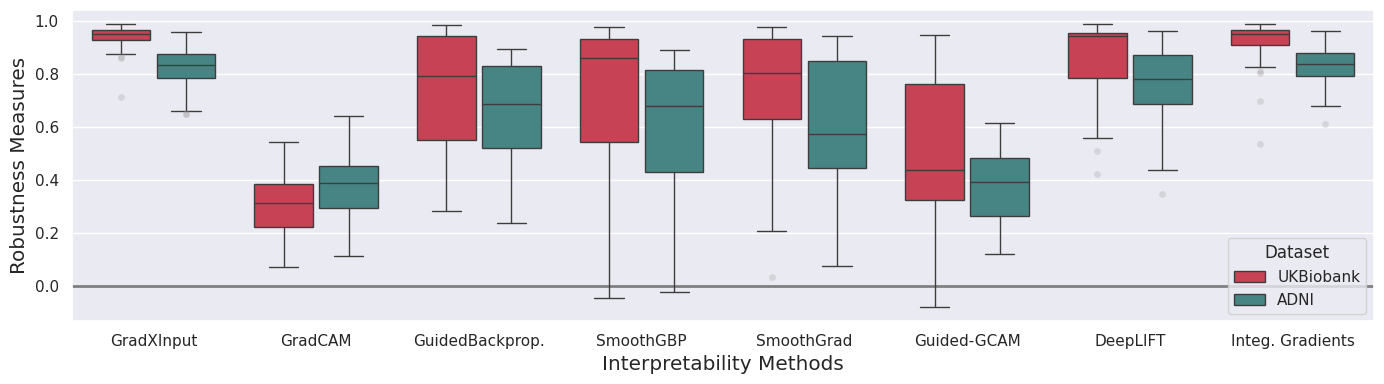

In [25]:
robustness["Dataset"] = "UKBiobank"
robustness_adni["Dataset"] = "ADNI"
rob_all = pd.concat([robustness, robustness_adni])
rob_all = rob_all[rob_all["Similarity Method"] == "SpearmanR"].reset_index(drop=True)
fig = boxplot(data=rob_all, ylabel="Robustness Measures", hue_col="Dataset",
              palette=[C.ukb_cmap[3], C.adni_cmap[3]], legend_loc="lower right")
fig.tight_layout()
fig.savefig("robustness_box.pdf", format="pdf", dpi=100)

In [27]:
measures = pd.merge(left=rob_all.rename({"Similarity": "Robustness"}, axis=1),
                    right=con_all.rename({"Similarity": "Consensus"}, axis=1),
                    on=["XAI Method", "Model Key", "Dataset"])[["XAI Method", "Robustness", "Consensus", "Model Key", "Dataset"]]
xai_names = measures["XAI Method"].unique().tolist()
measures

XAI Method  Robustness  Consensus        Model Key    Dataset
0             DeepLIFT    0.987447   0.880446  convnext-base-2  UKBiobank
1              GradCAM    0.327877   0.292795  convnext-base-2  UKBiobank
2           GradXInput    0.987447   0.929445  convnext-base-2  UKBiobank
3          Guided-GCAM    0.922623   0.498779  convnext-base-2  UKBiobank
4      GuidedBackprop.    0.984299   0.754183  convnext-base-2  UKBiobank
...                ...         ...        ...              ...        ...
1435       Guided-GCAM    0.480691   0.401660    densenet121-1       ADNI
1436   GuidedBackprop.    0.736900   0.640341    densenet121-1       ADNI
1437  Integ. Gradients    0.858953   0.835042    densenet121-1       ADNI
1438         SmoothGBP    0.520840   0.597625    densenet121-1       ADNI
1439        SmoothGrad    0.321616   0.171610    densenet121-1       ADNI

[1440 rows x 5 columns]

In [26]:
def biplot(measures: pd.DataFrame, title: str = "", plot_legend: bool = True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    xai_stats = measures.groupby("XAI Method").agg({
        "Robustness": ["mean", "std"],
        "Consensus": ["mean", "std"],
    }).reset_index()
    xai_stats.columns = ['xai', 'rob_mean', 'rob_std', 'con_mean', 'con_std']

    cmap = sns.color_palette("deep")
    for i, xai in enumerate(C.XAI_METHODS_MAPPER.values()):
        xai_data = xai_stats[xai_stats['xai'] == xai]

        color = cmap[i]
        ax.errorbar(
            x=xai_data['rob_mean'], 
            y=xai_data['con_mean'],
            xerr=xai_data['rob_std'],
            yerr=xai_data['con_std'],
            fmt="o",
            label=f"{xai}",
            color=color,
            markersize=8,
            capsize=3,
            capthick=1,
            elinewidth=1
        )
    
    # Linear
    sns.lineplot(x=np.linspace(0, 1, 100), y=np.linspace(0, 1, 100), ax=ax,
                    color="k", alpha=0.5, linewidth=4, linestyle="--")
    # Area
    sns.kdeplot(data=measures, x="Robustness", y="Consensus", hue="XAI Method", ax=ax,
                fill=True, alpha=0.3, hue_order=list(C.XAI_METHODS_MAPPER.values()))
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)

    ax.set_xlabel("Robustness", fontsize=16)
    ax.set_ylabel("Consensus", fontsize=16)

    if plot_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

    ax.tick_params(axis='both', which='minor', width=1, length=3)
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)

In [ ]:
style = ["^", "^", "^", "o", "o", "o", "s", "s", "s"]
style = ["^", "^", "^", "o", "o", "o", "s", "s", "s"]
style_order = list(C.MODEL_KEY.keys())
markers = {m: s for s, m in zip(style, C.MODEL_ARCH_KEY.values())}

# 공통 설정을 적용하는 데코레이터
def setup_ax(func):
    def wrapper(*args, **kwargs):
        ax = kwargs.get('ax', None)
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            kwargs['ax'] = ax  # ax를 함수 인자에 추가

        result = func(*args, **kwargs)  # 원래 함수 실행
        
        # 공통 설정 적용
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel("Robustness", fontsize=16)
        ax.set_ylabel("Consensus", fontsize=16)
        ax.tick_params(axis='both', which='minor', width=1, length=3)
        ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
        
        plot_legend = kwargs.get('plot_legend', True)
        if plot_legend:
            legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                               labelspacing=0.4,
                               title_fontsize=14)
            # legend.set_title("", prop={"weight", "bold"})
        else:
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
                
        title = kwargs.get("title", "")
        if title:
            ax.set_title(title, size="x-large")

        return result
    return wrapper

# 새로운 그래프를 그리는 함수
@setup_ax
def scatter(measures: pd.DataFrame, ax=None, plot_legend=True, title: str = "",
            scatter_alpha: float = None, palette=None):
    sns.lineplot(x=np.linspace(0, 1, 100), y=np.linspace(0, 1, 100), ax=ax,
                 color="k", alpha=0.5, linewidth=4, linestyle="--")
    sns.kdeplot(data=measures, x="Robustness", y="Consensus", hue="XAI Method", ax=ax, palette=palette,
                fill=True, alpha=0.4, hue_order=list(C.XAI_METHODS_MAPPER.values()))

    _m = measures.copy()
    _m.loc[:, "Model"] = _m["Model Key"].apply(lambda x: "-".join(x.split("-")[:-1]))
    _m = _m.groupby(["XAI Method", "Model"]).agg({"Robustness": "mean", "Consensus": "mean"}).reset_index()
    _m.loc[:, "Model Architecture"] = _m["Model"].apply(C.MODEL_ARCH_KEY.get)
    sns.scatterplot(data=_m, x="Robustness", y="Consensus", hue="XAI Method", palette=palette,
                    hue_order=list(C.XAI_METHODS_MAPPER.values()), ax=ax, alpha=scatter_alpha,
                    s=50, style="Model Architecture", markers=markers)
    
    mask = ~measures.isna().sum(axis=1).astype(bool).values
    r, p_value = pearsonr(measures[mask].Robustness, measures[mask].Consensus)
    ax.text(0.05, 0.95, f"Pearson R = {r:.3f}\n(p={p_value:.3f})",
            transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    return ax

<Axes: title={'center': 'ADNI'}, xlabel='Robustness', ylabel='Consensus'>

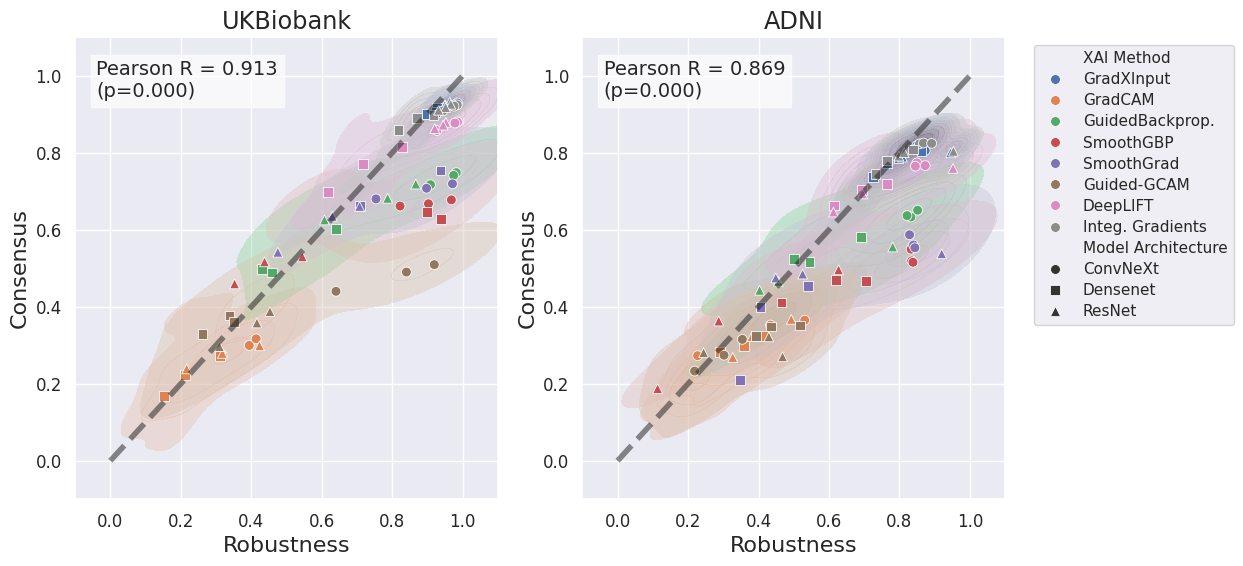

In [38]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

m_ukb = measures[measures.Dataset == "UKBiobank"]
scatter(measures=m_ukb, ax=ax[0], plot_legend=False, title="UKBiobank", palette=None)

m_adni = measures[measures.Dataset == "ADNI"]
scatter(measures=m_adni, ax=ax[1], title="ADNI", palette=None)

# fig.savefig("measures_ukb_adni.pdf", format="pdf", dpi=100, bbox_inches='tight')

<Axes: title={'center': 'ADNI'}, xlabel='Robustness', ylabel='Consensus'>

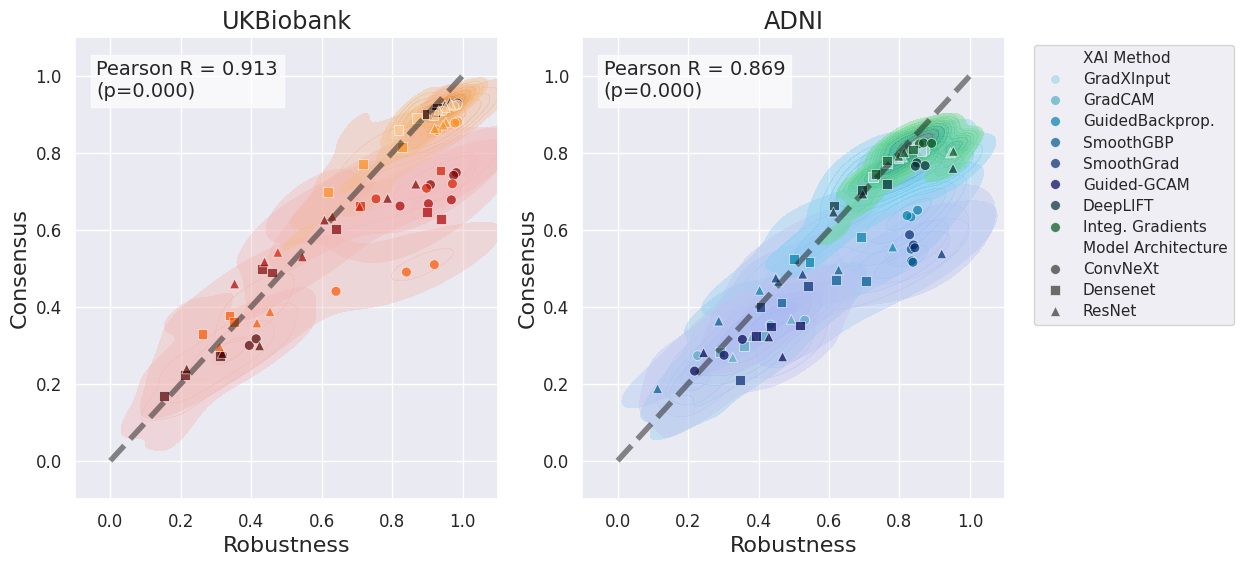

In [39]:
sa = 0.7
p1 = sns.color_palette(palette="gist_heat", n_colors=len(C.XAI_METHODS))
p2 = sns.color_palette(palette="ocean_r", n_colors=len(C.XAI_METHODS))

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

m_ukb = measures[measures.Dataset == "UKBiobank"]
scatter(measures=m_ukb, ax=ax[0], plot_legend=False, title="UKBiobank", palette=p1, scatter_alpha=sa)

m_adni = measures[measures.Dataset == "ADNI"]
scatter(measures=m_adni, ax=ax[1], title="ADNI", palette=p2, scatter_alpha=sa)

# fig.savefig("measures_ukb_adni.pdf", format="pdf", dpi=100, bbox_inches='tight')

pearsonr: subgroup 별로도 진행해보기

In [61]:
mask_ukb = ~m_ukb.isna().sum(axis=1).astype(bool).values
m_ukb_ = m_ukb[mask_ukb]

mask_adni = ~m_adni.isna().sum(axis=1).astype(bool).values
m_adni_ = m_adni[mask_adni]

mask_all = mask_ukb & mask_adni

In [62]:
pearsonr(m_ukb_.Robustness, m_ukb_.Consensus)

PearsonRResult(statistic=0.904567552199985, pvalue=7.129036430292922e-283)

In [63]:
pearsonr(m_adni_.Robustness, m_adni_.Consensus)

PearsonRResult(statistic=0.8695390828169726, pvalue=1.7788914640674445e-249)

In [ ]:
pearsonr(m_ukb[mask_all].Robustness, m_adni[mask_all].Robustness)

PearsonRResult(statistic=0.6506998861363285, pvalue=1.3683411621864696e-92)

In [67]:
pearsonr(m_ukb[mask_all].Consensus, m_adni[mask_all].Consensus)

PearsonRResult(statistic=0.7598030816853212, pvalue=1.0815693043570075e-143)

모델 단위로 average 때린거
```python
_df["Model Key"] = df.Source.apply(lambda m: "-".join(m.split("-")[:-1]))
robustness_df = _df.groupby(["XAI Method", "Model Key", "Similarity Method"]).agg({"Similarity": "mean"}).reset_index()

fig, ax = plt.subplots(figsize=(14, 4))
ax.axhline(0, color="gray", linewidth=2)
boxplot(data=robustness_df, ylabel="Robustness (-1 to 1)", ax=ax)```

## 3. Alignment

In [20]:
alignment = m.load_alignment(scratch=False)
metadata = m.load_metadata()

Load from /home/daehyun/codespace/brain-age-prediction/RQ/assets/full_alignment_241113.csv


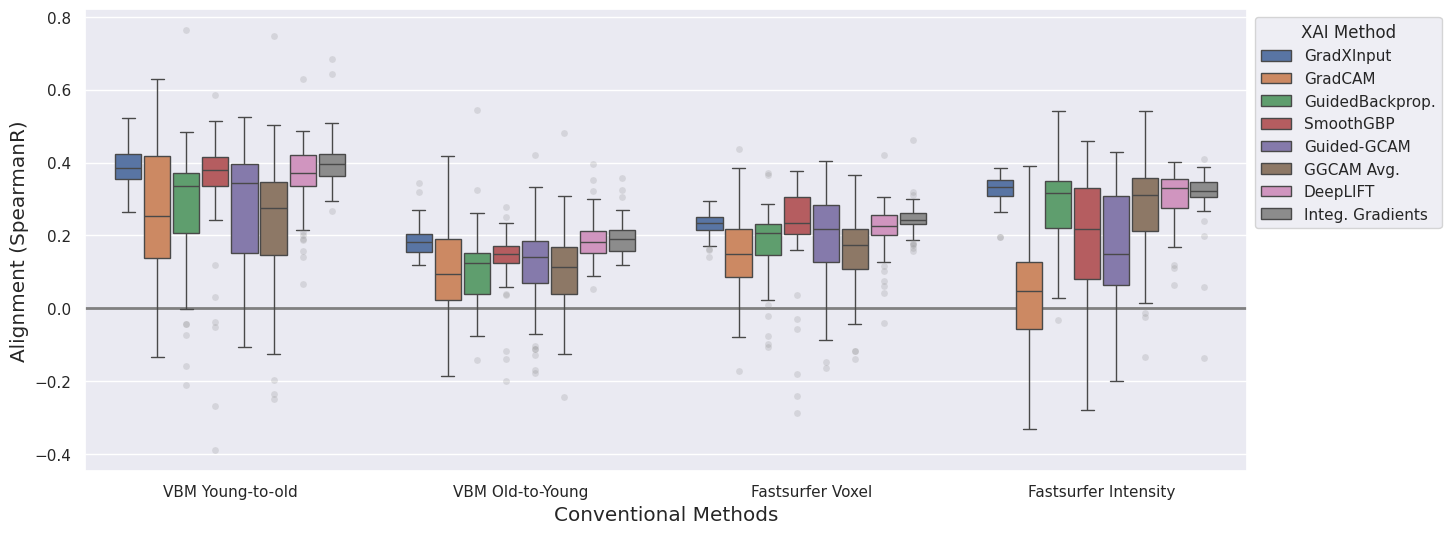

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
boxplot(data=alignment, x_col=C.HUECOL, hue_col=C.XCOL, order=list(metadata.keys()),
        xlabel="Conventional Methods", ylabel="Alignment (SpearmanR)", ax=ax)

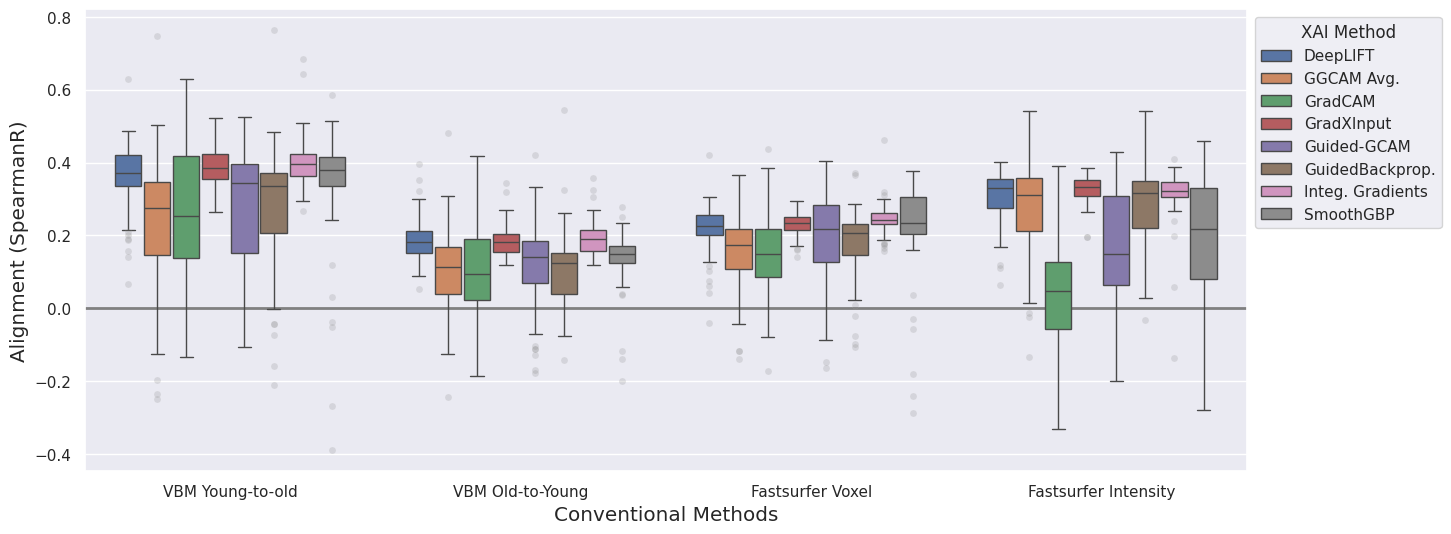

In [22]:
align_gb = alignment.groupby(["XAI Method", "Model Key", "Similarity Method"]).agg({"Similarity": "mean"}).reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
boxplot(data=align_gb, x_col=C.HUECOL, hue_col=C.XCOL, order=list(metadata.keys()),
        xlabel="Conventional Methods", ylabel="Alignment (SpearmanR)", ax=ax)

## 4. ML-Training

In [5]:
cmapper = { # Model to index
    "ResNet10": 0,
    "ResNet18": 0,
    "ResNet34": 0,
    "ConvNeXt-Tiny": 1,
    "ConvNeXt-Small": 1,
    "ConvNeXt-Base": 1,
    "Densenet121": 2,
    "Densenet169": 2,
    "Densenet264d": 2,
}


In [6]:
def plot_age_ml(metric: str, perf_table: pd.DataFrame, sort_by_perf: bool = True,
                 plot_type: str = "box", cmap: str = "light:b", save: str = ""):
    # Rename contents to mapper
    df = perf_table.copy()
    df["Model Key"] = df["Model Key"].apply(lambda m: "-".join(m.split("-")[:-1]))
    df["Model Key"] = df["Model Key"].apply(C.MODEL_KEY.get)

    # Sort data
    if sort_by_perf:
        custom_order = df.groupby("XAI Method").agg({metric: "mean"}).sort_values(by=metric).index.tolist()

    # Plot data
    fig, ax = plt.subplots(figsize=(14, 4))
    # Plot Average
    avg_perf = C.PERF_AVG[metric] if metric in C.PERF_AVG else C.PERF_AVG_ADNI[metric]
    ax.axhline(avg_perf, linestyle="--", color="k", label=f"Baseline {metric.upper()}")
    avg = df.groupby("XAI Method").agg({metric: "mean"}).sort_values(by=metric).reset_index()
    ax.scatter(x=avg["XAI Method"], y=avg[metric], label=f"Average {metric.upper()}",
                marker="*", color="red", s=300, edgecolors="white", zorder=10)
    if plot_type == "box":    
        # Plot box
        flierprops = dict(marker='o', markerfacecolor="gray", markersize=5,
                          markeredgecolor='white', markeredgewidth=.2, alpha=0.4)
        
        palette = {m: cmap[v] for m, v in cmapper.items()}
        sns.boxplot(data=df, x="XAI Method", y=metric, hue="Model Key",
                    palette=palette, ax=ax, flierprops=flierprops)

    elif plot_type == "bar":
        sns.barplot(data=df, x="XAI Method", y=metric, hue="Model Key",
                    palette=cmap, ax=ax)
    ax.set_xlabel("Interpretability Methods", size="large")
    ax.set_ylabel({"mae": "Mean Average Error",
                   "mse": "Mean Squared Error",
                   "r2": "R-squared",
                   "f1": "F1-Score",
                   "acc": "Accuracy",
                   "auroc": "Area Under ROC"}[metric], size="large")
    sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1, 1))
    fig.tight_layout()
    if save:
        fig.savefig(f"{save}.pdf", format="pdf", dpi=100)

In [ ]:
age_lgbm = pd.read_csv("assets/lgbm_ukb_250312.csv")
age_lgbm = age_lgbm[age_lgbm["XAI Method"].isin(C.XAI_METHODS)]
age_lgbm = age_lgbm.replace(to_replace=C.XAI_METHODS_MAPPER)

age_knn = pd.read_csv("assets/knn_ukb_250312.csv")
age_knn = age_knn[age_knn["XAI Method"].isin(C.XAI_METHODS)]
age_knn = age_knn.replace(to_replace=C.XAI_METHODS_MAPPER)

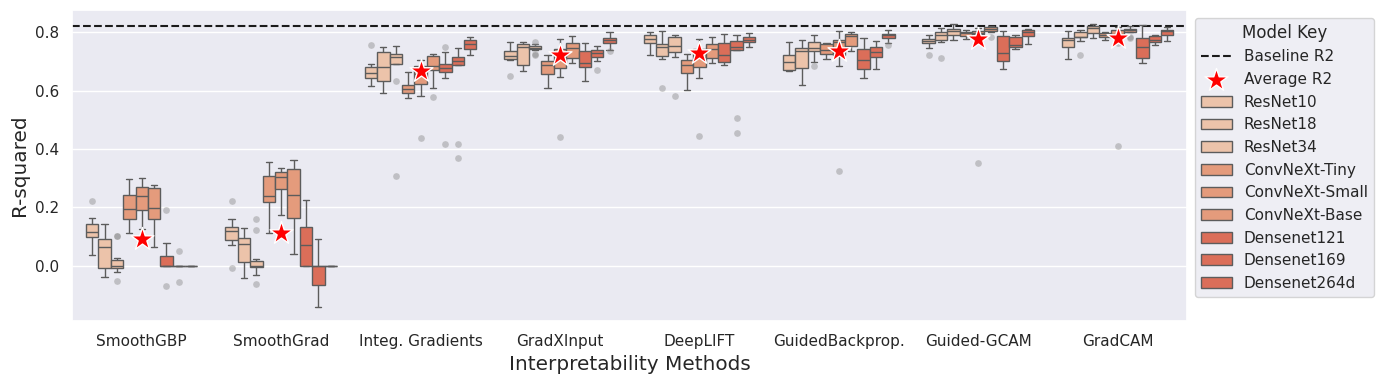

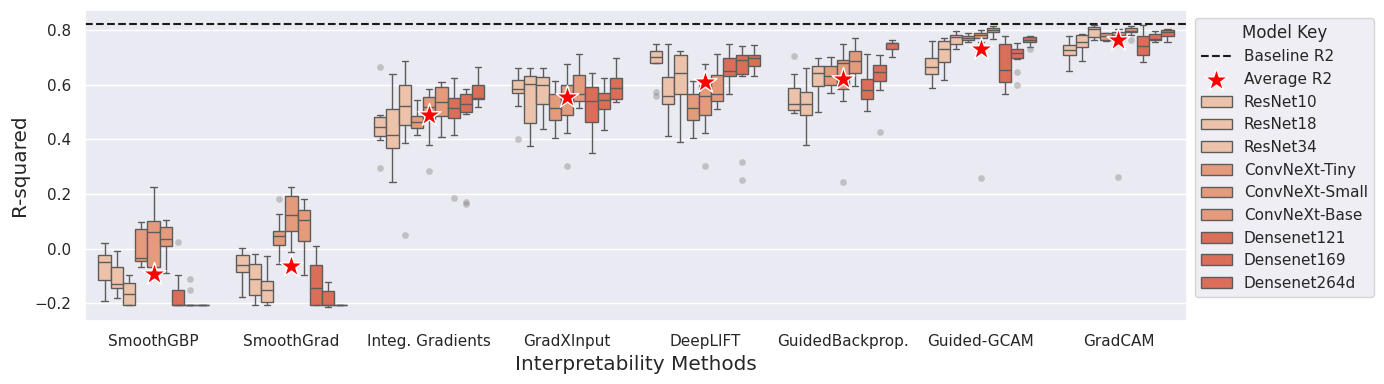

In [12]:
plot_age_ml(metric="r2", perf_table=age_lgbm, cmap=C.ukb_cmap)
plot_age_ml(metric="r2", perf_table=age_knn , cmap=C.ukb_cmap)

In [8]:
adni_lgbm = pd.read_csv("assets/lgbm_adni_250312.csv")
adni_lgbm = adni_lgbm[adni_lgbm["XAI Method"].isin(C.XAI_METHODS)]
adni_lgbm = adni_lgbm.replace(to_replace=C.XAI_METHODS_MAPPER)

adni_knn = pd.read_csv("assets/knn_adni_250312.csv")
adni_knn = adni_knn[adni_knn["XAI Method"].isin(C.XAI_METHODS)]
adni_knn = adni_knn.replace(to_replace=C.XAI_METHODS_MAPPER)

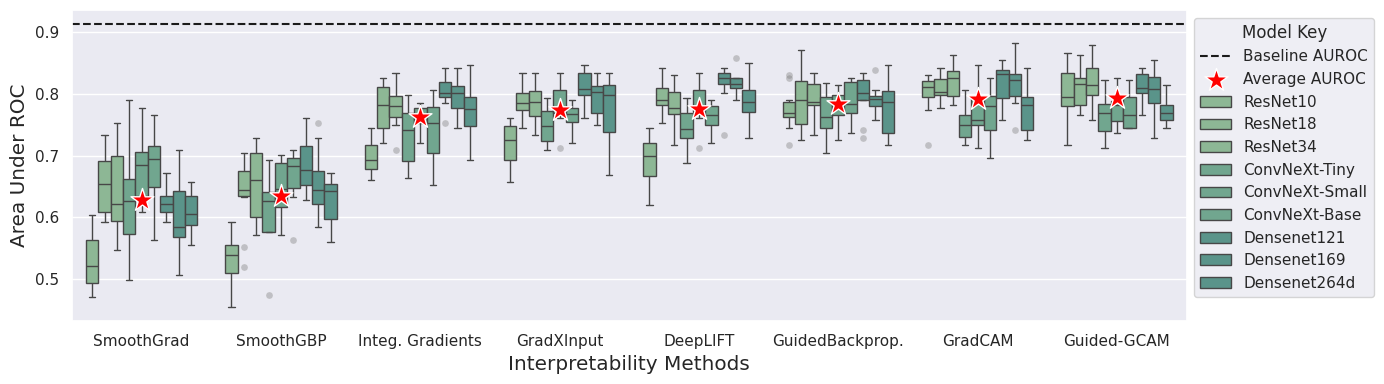

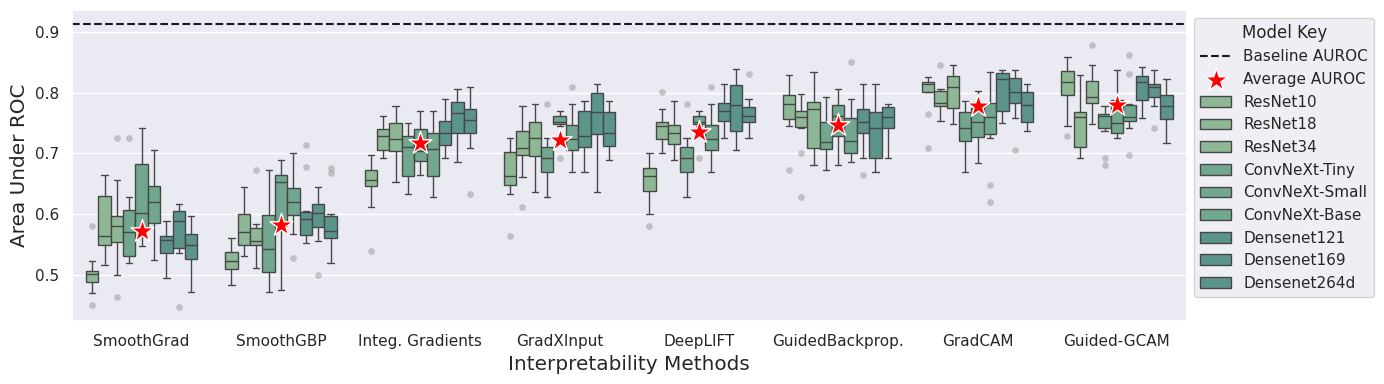

In [10]:
plot_age_ml(metric="auroc", perf_table=adni_lgbm, cmap=C.adni_cmap)
plot_age_ml(metric="auroc", perf_table=adni_knn , cmap=C.adni_cmap)

## 5. All Values

In [27]:
consensus.groupby(["XAI Method", "Similarity Method"]).agg(
    mean=("Similarity", "mean"),
    std=("Similarity", "std"),
    min=("Similarity", "min"),
    max=("Similarity", "max"),
    q25=("Similarity", lambda x: np.percentile(x, 25)),
    median=("Similarity", lambda x: np.percentile(x, 50)),
    q75=("Similarity", lambda x: np.percentile(x, 75))
)

mean       std       min       max  \
XAI Method       Similarity Method                                           
DeepLIFT         L2                 0.905378  0.045427  0.730095  0.943401   
                 SpearmanR          0.834844  0.086500  0.375969  0.895701   
GGCAM Avg.       L2                 0.711038  0.079488  0.462765  0.797157   
                 SpearmanR          0.556418  0.142204  0.120385  0.687964   
GradCAM          L2                 0.807462  0.034448  0.673156  0.866726   
                 SpearmanR          0.263371  0.082799  0.020829  0.419591   
GradXInput       L2                 0.925776  0.035276  0.741913  0.954032   
                 SpearmanR          0.917746  0.030700  0.696508  0.942969   
Guided-GCAM      L2                 0.308549  0.131599  0.000386  0.476756   
                 SpearmanR          0.394303  0.138275 -0.100541  0.555886   
GuidedBackprop.  L2                 0.776279  0.064372  0.561150  0.839974   
                 SpearmanR          0.646895  0.129965  0.124144  0.754558   
Integ. Gradients L2                 0.912906  0.040782  0.739341  0.943999   
                 SpearmanR          0.906060  0.047341  0.580112  0.935484   
SmoothGBP        L2                 0.371064  0.257886  0.000000  0.659525   
                 SpearmanR          0.598814  0.190496 -0.052054  0.740440   

                                         q25    median       q75  
XAI Method       Similarity Method                                
DeepLIFT         L2                 0.893318  0.927004  0.933810  
                 SpearmanR          0.829695  0.873398  0.881016  
GGCAM Avg.       L2                 0.674459  0.746780  0.768765  
                 SpearmanR          0.496811  0.620735  0.656563  
GradCAM          L2                 0.796478  0.812688  0.829619  
                 SpearmanR          0.211634  0.273704  0.313585  
GradXInput       L2                 0.919652  0.939027  0.943699  
                 SpearmanR          0.916853  0.926172  0.931153  
Guided-GCAM      L2                 0.214302  0.302467  0.438918  
                 SpearmanR          0.314465  0.428361  0.503322  
GuidedBackprop.  L2                 0.743390  0.799750  0.825300  
                 SpearmanR          0.576460  0.707804  0.740498  
Integ. Gradients L2                 0.907820  0.929887  0.936934  
                 SpearmanR          0.908043  0.919128  0.926545  
SmoothGBP        L2                 0.000000  0.534547  0.566626  
                 SpearmanR               NaN       NaN       NaN

In [28]:
def parse_mean_std(p):
    return f"{np.mean(p):.3f} ± {np.std(p):.3f}"

# Create separate tables for L2 and SpearmanR
l2_consensus = consensus[consensus["Similarity Method"] == "L2"].groupby("XAI Method").agg(**{"Consensus L2": ("Similarity", parse_mean_std)})
spearman_consensus = consensus[consensus["Similarity Method"] == "SpearmanR"].groupby("XAI Method").agg(**{"Consensus SpearmanR": ("Similarity", parse_mean_std)})

l2_robustness = robustness[robustness["Similarity Method"] == "L2"].groupby("XAI Method").agg(**{"Robustness L2": ("Similarity", parse_mean_std)})
spearman_robustness = robustness[robustness["Similarity Method"] == "SpearmanR"].groupby("XAI Method").agg(**{"Robustness SpearmanR": ("Similarity", parse_mean_std)})

# Get age_lgbm mean±std
stats_lgbm = age_lgbm.groupby("XAI Method").agg(**{"LightGBM MAE": ("mae", parse_mean_std)})
stats_knn = age_knn.groupby("XAI Method").agg(**{"KNN MAE": ("mae", parse_mean_std)})

# Combine all tables
cr = pd.concat([l2_consensus, spearman_consensus, l2_robustness, spearman_robustness], axis=1)

def format_mean_std(group):
    return f"{group['Similarity'].mean():.3f} ± {group['Similarity'].std():.3f}"

align = pd.pivot_table(
    data=alignment,
    index="XAI Method", 
    columns="Similarity Method",
    values="Similarity",
    aggfunc=lambda x: format_mean_std(pd.DataFrame({'Similarity': x}))
)

In [29]:
pd.concat([cr, align, stats_lgbm, stats_knn], axis=1)

Consensus L2 Consensus SpearmanR  Robustness L2  \
XAI Method                                                           
DeepLIFT          0.905 ± 0.045       0.835 ± 0.086  0.932 ± 0.060   
GGCAM Avg.        0.711 ± 0.079       0.556 ± 0.141  0.772 ± 0.137   
GradCAM           0.807 ± 0.034       0.263 ± 0.082  0.819 ± 0.052   
GradXInput        0.926 ± 0.035       0.918 ± 0.031  0.949 ± 0.040   
Guided-GCAM       0.309 ± 0.131       0.394 ± 0.138  0.445 ± 0.316   
GuidedBackprop.   0.776 ± 0.064       0.647 ± 0.129  0.840 ± 0.126   
Integ. Gradients  0.913 ± 0.041       0.906 ± 0.047  0.935 ± 0.062   
SmoothGBP         0.371 ± 0.256       0.599 ± 0.189  0.540 ± 0.418   

                 Robustness SpearmanR Fastsurfer Intensity Fastsurfer Voxel  \
XAI Method                                                                    
DeepLIFT                0.875 ± 0.129        0.309 ± 0.065    0.219 ± 0.063   
GGCAM Avg.              0.650 ± 0.228        0.281 ± 0.118    0.155 ± 0.094   
GradCAM                 0.307 ± 0.109        0.040 ± 0.131    0.158 ± 0.115   
GradXInput              0.945 ± 0.037        0.329 ± 0.034    0.233 ± 0.028   
Guided-GCAM             0.503 ± 0.263        0.171 ± 0.145    0.195 ± 0.118   
GuidedBackprop.         0.740 ± 0.210        0.286 ± 0.102    0.180 ± 0.086   
Integ. Gradients        0.929 ± 0.066        0.318 ± 0.065    0.245 ± 0.037   
SmoothGBP               0.715 ± 0.271        0.189 ± 0.168    0.218 ± 0.130   

                 VBM Old-to-Young VBM Young-to-old   LightGBM MAE  \
XAI Method                                                          
DeepLIFT            0.187 ± 0.054    0.364 ± 0.087  3.133 ± 0.363   
GGCAM Avg.          0.100 ± 0.109    0.241 ± 0.164  2.831 ± 0.298   
GradCAM             0.103 ± 0.110    0.270 ± 0.171  2.813 ± 0.274   
GradXInput          0.183 ± 0.039    0.386 ± 0.044  3.179 ± 0.274   
Guided-GCAM         0.118 ± 0.113    0.279 ± 0.172  3.289 ± 0.871   
GuidedBackprop.     0.106 ± 0.097    0.277 ± 0.153  3.101 ± 0.328   
Integ. Gradients    0.191 ± 0.043    0.398 ± 0.059  3.460 ± 0.428   
SmoothGBP           0.137 ± 0.079    0.343 ± 0.166  5.980 ± 0.419   

                        KNN MAE  
XAI Method                       
DeepLIFT          3.773 ± 0.515  
GGCAM Avg.        3.108 ± 0.408  
GradCAM           2.920 ± 0.331  
GradXInput        4.032 ± 0.383  
Guided-GCAM       3.521 ± 1.010  
GuidedBackprop.   3.701 ± 0.466  
Integ. Gradients  4.310 ± 0.492  
SmoothGBP         6.555 ± 0.389

In [30]:
age_lgbm.groupby(["XAI Method"]).agg(
    mean=("mae", "mean"),
    std=("mae", "std"),
    min=("mae", "min"),
    max=("mae", "max"),
    q25=("mae", lambda x: np.percentile(x, 25)),
    median=("mae", lambda x: np.percentile(x, 50)),
    q75=("mae", lambda x: np.percentile(x, 75))
)

mean       std       min       max       q25    median  \
XAI Method                                                                     
DeepLIFT          3.133087  0.364932  2.666085  4.580427  2.887579  3.049920   
GGCAM Avg.        2.831028  0.299450  2.518180  4.949929  2.680208  2.754953   
GradCAM           2.812882  0.275075  2.508252  4.717951  2.665635  2.762250   
GradXInput        3.179465  0.275415  2.727856  4.603835  2.987337  3.132956   
Guided-GCAM       3.288694  0.876126  2.519118  6.407446  2.720172  2.893187   
GuidedBackprop.   3.100797  0.330295  2.647155  5.070808  2.894506  3.060455   
Integ. Gradients  3.459647  0.430622  2.821113  5.161144  3.178546  3.396729   
SmoothGBP         5.979954  0.421295  5.140678  6.520878  5.657141  6.001940   

                       q75  
XAI Method                  
DeepLIFT          3.289563  
GGCAM Avg.        2.892587  
GradCAM           2.868421  
GradXInput        3.311996  
Guided-GCAM       3.439868  
GuidedBackprop.   3.267077  
Integ. Gradients  3.654173  
SmoothGBP         6.407446

# 2. Correlation betwen Measurements

In [ ]:
PIVOT_COLS = ["XAI Method", "Model Key"]
def plot_corr(x: pd.DataFrame, y: pd.DataFrame, x_col: str, y_col: str, plot_type: str = "kde",
              xlim: list = [-0.05, 1.05], ylim: list = [-0.05, 1.05],
              plot_identity: bool = False, show_legend: bool = False,
              ax=None, title: str = None):
    data_plot = x.reset_index(drop=True).merge(y.reset_index(drop=True), on=PIVOT_COLS)
    data_plot = data_plot.rename({"Similarity_x": x_col, "Similarity_y": y_col}, axis=1)

    # PLOT
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    if plot_identity:
        sns.lineplot(x=np.linspace(0, 1, 100), y=np.linspace(0, 1, 100), ax=ax,
                     color="k", alpha=0.5, linewidth=4, linestyle="--")

    if plot_type == "kde":
        sns.kdeplot(data=data_plot, x=x_col, y=y_col, hue="XAI Method", fill=True, alpha=0.3,
                    legend=show_legend, ax=ax)
        sns.scatterplot(data=data_plot, x=x_col, y=y_col, hue="XAI Method",
                        legend=show_legend, ax=ax)

    elif plot_type == "reg":
        for xai in sorted(data_plot["XAI Method"].unique()):
            sns.regplot(data=data_plot[data_plot["XAI Method"] == xai], order=1, label=xai,
                        x=x_col, y=y_col, ax=ax)

    ax.set_title(f"{x_col} - {y_col}" if title is None else title, size="x-large")
    ax.set_xlabel(x_col, size="x-large")
    ax.set_ylabel(y_col, size="x-large")
    if show_legend:
        ax.legend(title="XAI Method")
        sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1, 1))
    
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)

## Metrics Comparison: L2 vs. SpearmanR

우선 L2랑 SpearmanR이라는 metric 자체가 서로 연관성이 있는지 확인.

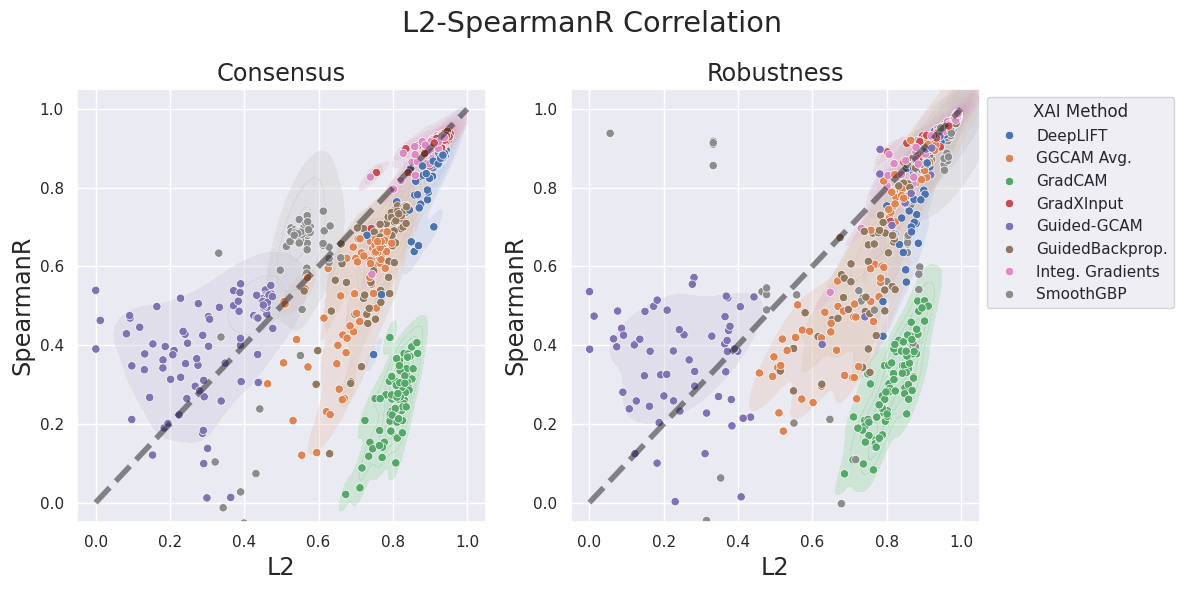

In [32]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

a = consensus[(consensus["Similarity Method"] == "L2")]
b = consensus[(consensus["Similarity Method"] == "SpearmanR")]
plot_corr(x=a, x_col="L2", y=b, y_col="SpearmanR", show_legend=False, plot_identity=True,
          title="Consensus", ax=ax[0])

a = robustness[(robustness["Similarity Method"] == "L2")]
b = robustness[(robustness["Similarity Method"] == "SpearmanR")]
plot_corr(x=a, x_col="L2", y=b, y_col="SpearmanR", show_legend=True, plot_identity=True,
          title="Robustness", ax=ax[1])

fig.suptitle("L2-SpearmanR Correlation", size="xx-large")
fig.tight_layout()

## Performance (R2) vs. Measurements

In [33]:
# Loading Performance Table
from weight_parser import WeightAvg
from pathlib import Path

r2_lim = [0.6, 0.9]
f1_lim = [0.5, 0.9]
metric_ukb, metric_adni = "r2", "f1"

avg_dict = dict()
avg_dict_adni = dict()
for model in C.MODELS:
    avg = WeightAvg(model_name=model, xai_method="", seeds=C.SEEDS)
    for idx, seed in enumerate(avg.seed_dict):
        wp = avg.seed_dict[seed] 
        avg_dict[f"{model}-{idx}"] = wp.test_performance[metric_ukb]

    avg = WeightAvg(model_name=f"{model}-binary", xai_method="", reg=False,
                    seeds=C.SEEDS, base_dir=Path("../adni_training/extra_final/extra"))
    for idx, seed in enumerate(avg.seed_dict):
        wp = avg.seed_dict[seed] 
        avg_dict_adni[f"{model}-{idx}"] = wp.test_performance[metric_adni]
        
xai_dummy = []
for xai in C.XAI_METHODS_MAPPER.values():
    xai_dummy.extend([xai] * 90)

pt_ukb = pd.DataFrame.from_dict(avg_dict, orient="index").reset_index()
pt_ukb.columns = ["Model Key", "Similarity"]
pt_ukb = pd.concat([pt_ukb for _ in range(len(C.XAI_METHODS))])
pt_ukb["XAI Method"] = xai_dummy

pt_adni = pd.DataFrame.from_dict(avg_dict_adni, orient="index").reset_index()
pt_adni.columns = ["Model Key", "Similarity"]
pt_adni = pd.concat([pt_adni for _ in range(len(C.XAI_METHODS))])
pt_adni["XAI Method"] = xai_dummy

performance_table = pd.concat([pt_ukb, pt_adni])

INFO:/home/daehyun/codespace/brain-age-prediction/RQ/weight_parser.py:Load all seeds: range(42, 52)


### Robustness/Consensus vs. R2

1. 같은 Performance에 대해서 consensus가 XAI별로 다르게 올라가나 ?

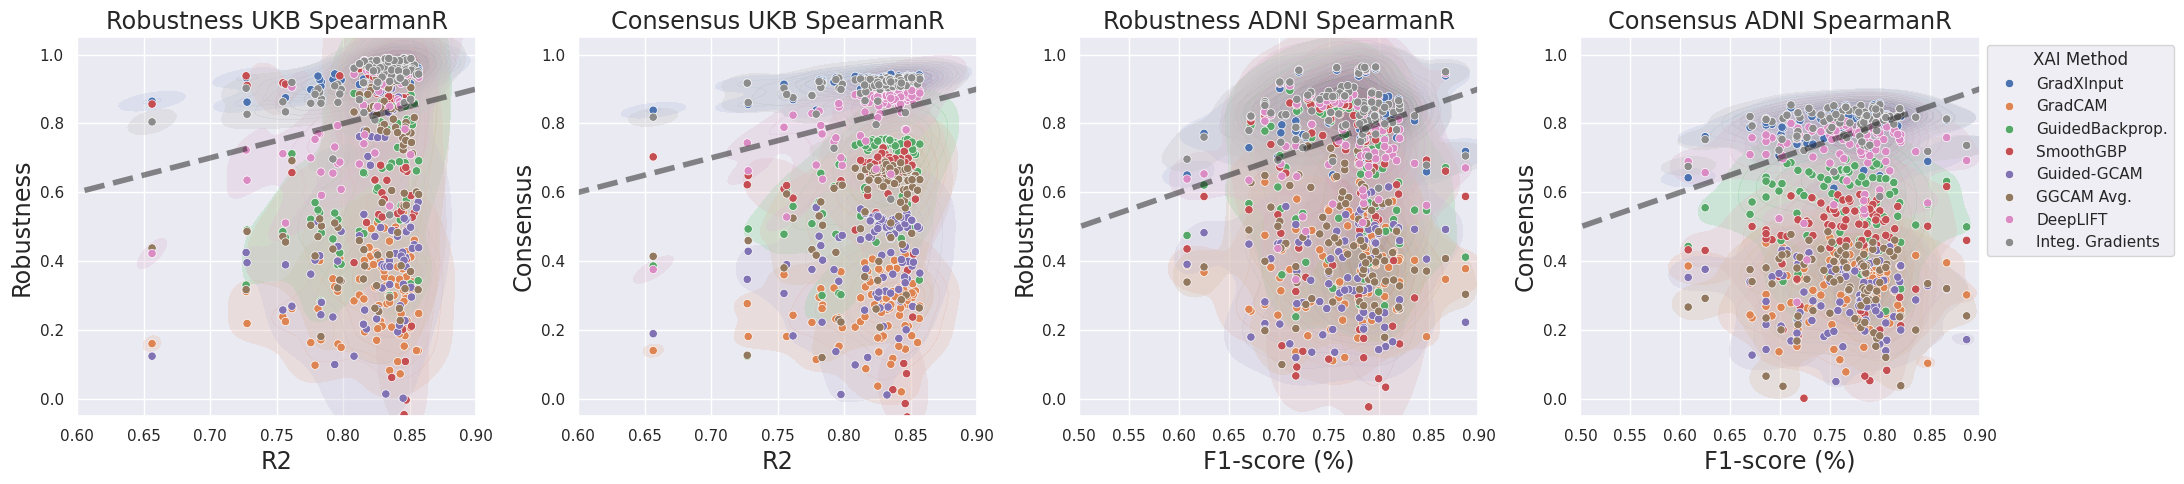

In [34]:
fig, ax = plt.subplots(figsize=(22, 5), ncols=4)
# fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

rob = robustness[(robustness["Similarity Method"] == "SpearmanR")]
plot_corr(y=rob, y_col="Robustness", x=pt_ukb, x_col="R2", show_legend=False, plot_identity=True,
          xlim=r2_lim, title="Robustness UKB SpearmanR", ax=ax[0])

con = consensus[(consensus["Similarity Method"] == "SpearmanR")]
plot_corr(y=con, y_col="Consensus", x=pt_ukb, x_col="R2", show_legend=False, plot_identity=True,
          xlim=r2_lim, title="Consensus UKB SpearmanR", ax=ax[1])

rob = robustness_adni[(robustness_adni["Similarity Method"] == "SpearmanR")]
plot_corr(y=rob, y_col="Robustness", x=pt_adni, x_col="F1-score (%)", show_legend=False, plot_identity=True,
          xlim=f1_lim, title="Robustness ADNI SpearmanR", ax=ax[2])

con = consensus_adni[(consensus_adni["Similarity Method"] == "SpearmanR")]
plot_corr(y=con, y_col="Consensus", x=pt_adni, x_col="F1-score (%)", show_legend=True, plot_identity=True,
          xlim=f1_lim, title="Consensus ADNI SpearmanR", ax=ax[3])

fig.tight_layout()

### Alignments vs. R2

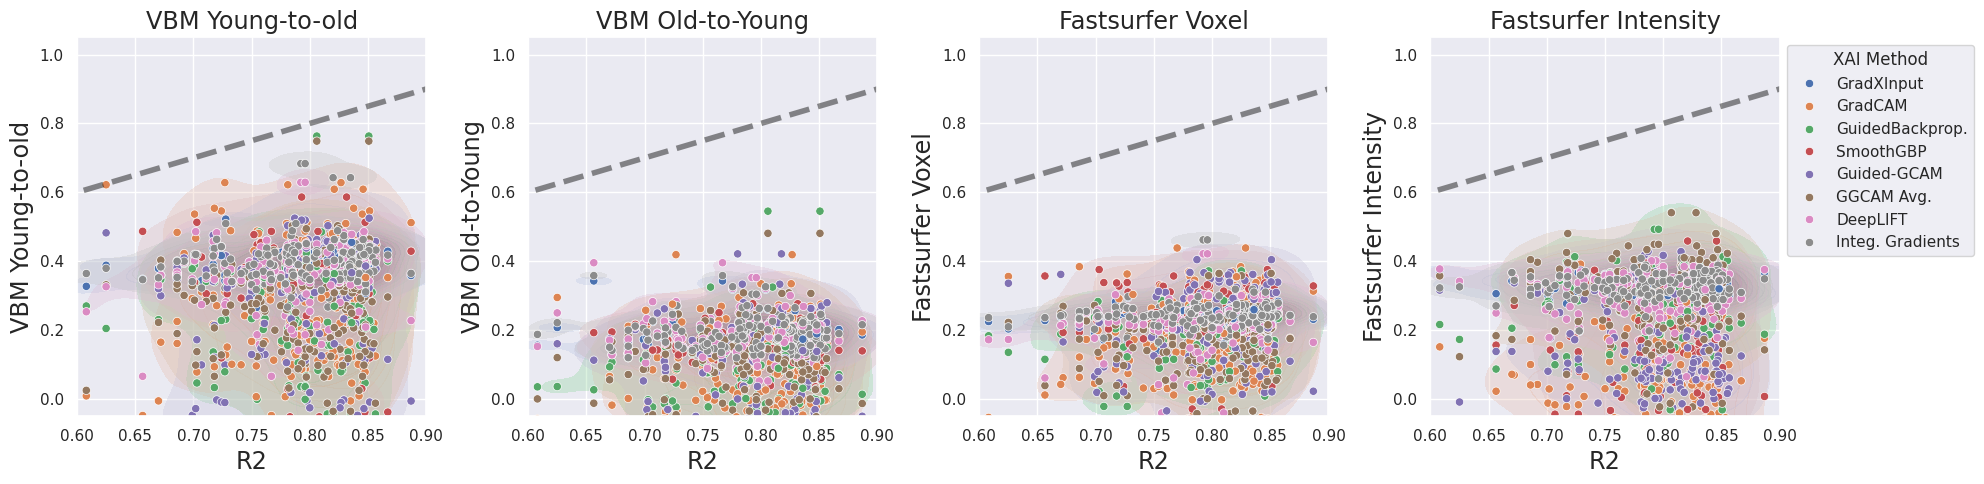

In [35]:
fig, ax = plt.subplots(figsize=(20, 5), ncols=4)
for idx, metakey in enumerate(metadata):
    ali = alignment[alignment["Similarity Method"] == metakey]
    show_legend = idx == (len(metadata) - 1)
    plot_corr(x=performance_table, x_col="R2", y=ali, y_col=metakey, show_legend=show_legend,
              plot_identity=True, xlim=r2_lim,
              title=f"{metakey}", ax=ax[idx])
# fig.suptitle("SpearmanR Robustness - Alignment Correlation", size="xx-large")
fig.tight_layout()

## Correlations between Measurements

### Robustness vs. Consensus

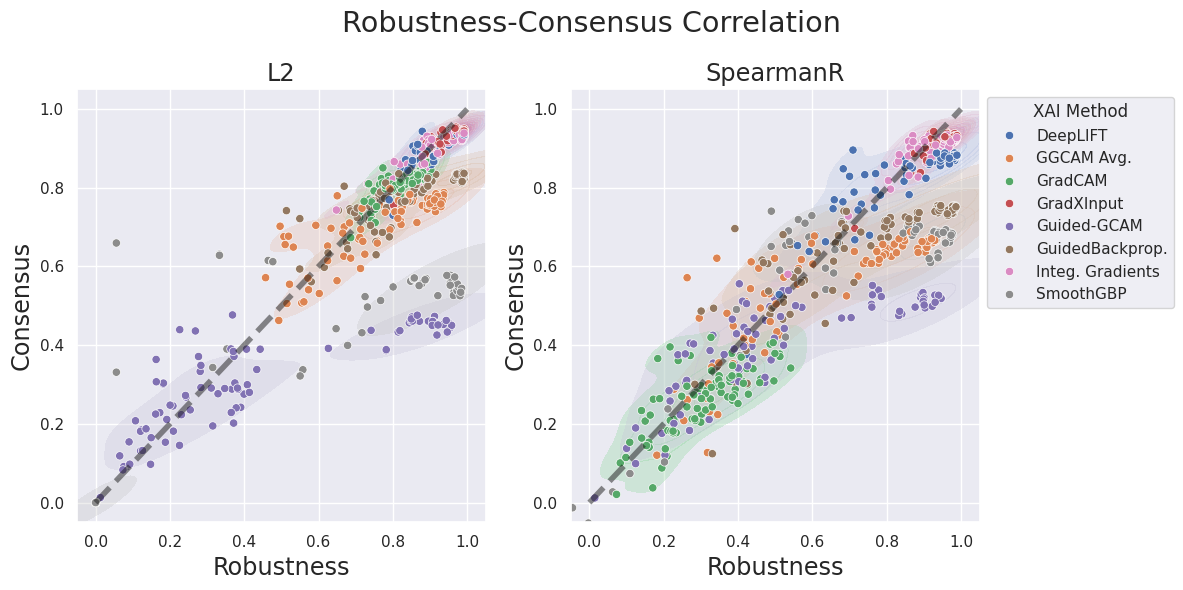

In [36]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

rob = robustness[(robustness["Similarity Method"] == "L2")]
con = consensus[(consensus["Similarity Method"] == "L2")]
plot_corr(x=rob, x_col="Robustness", y=con, y_col="Consensus", show_legend=False, plot_identity=True,
          title="L2", ax=ax[0])


rob = robustness[(robustness["Similarity Method"] == "SpearmanR")]
con = consensus[(consensus["Similarity Method"] == "SpearmanR")]
plot_corr(x=rob, x_col="Robustness", y=con, y_col="Consensus", show_legend=True, plot_identity=True,
          title="SpearmanR", ax=ax[1])

fig.suptitle("Robustness-Consensus Correlation", size="xx-large")
fig.tight_layout()

### Consensus vs. Alignment

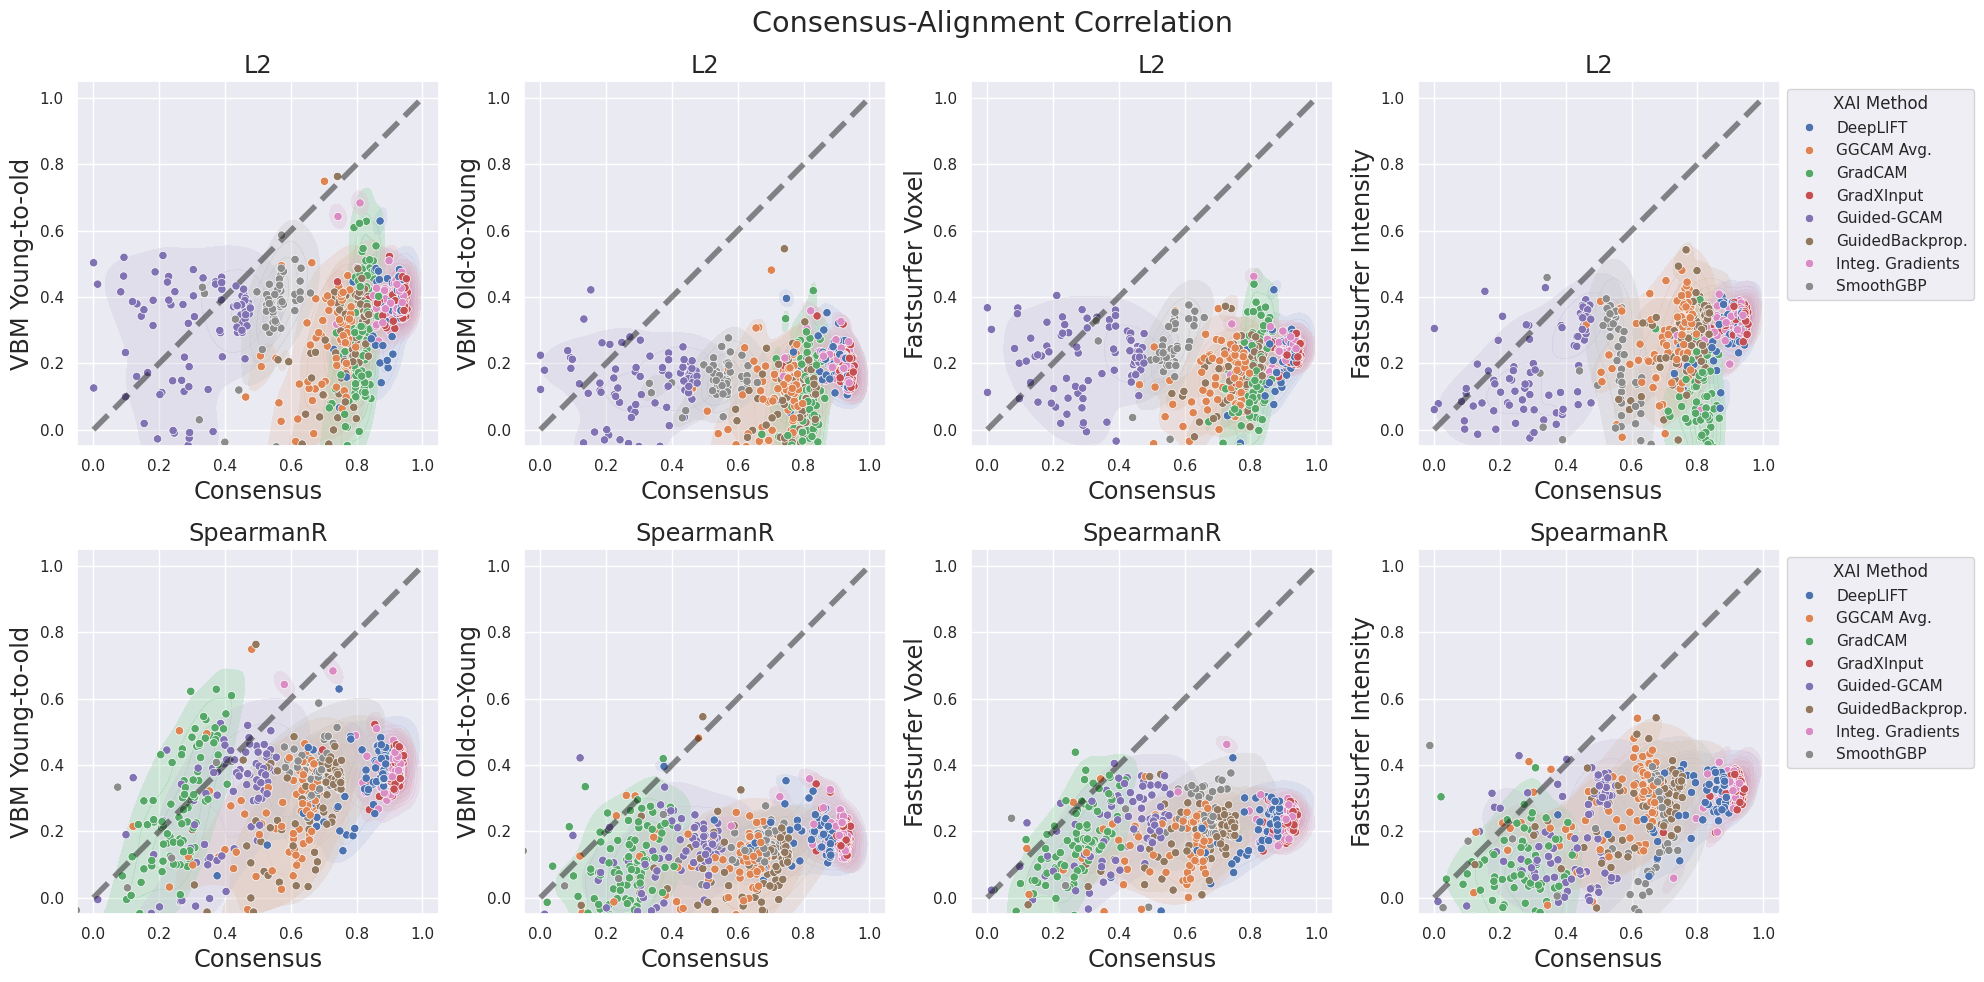

In [37]:
con_l2 = consensus[(consensus["Similarity Method"] == "L2")]
con_sr = consensus[(consensus["Similarity Method"] == "SpearmanR")]

fig, ax = plt.subplots(figsize=(20, 10), ncols=4, nrows=2)

for idx, metakey in enumerate(metadata):
    ali = alignment[alignment["Similarity Method"] == metakey]
    show_legend = idx == (len(metadata) - 1)
    plot_corr(x=con_l2, x_col="Consensus", y=ali, y_col=metakey, show_legend=show_legend, plot_identity=True,
              title="L2", ax=ax[0, idx])
    plot_corr(x=con_sr, x_col="Consensus", y=ali, y_col=metakey, show_legend=show_legend, plot_identity=True,
              title="SpearmanR", ax=ax[1, idx])
fig.suptitle("Consensus-Alignment Correlation", size="xx-large")
fig.tight_layout()

### Robustness vs. Alignment

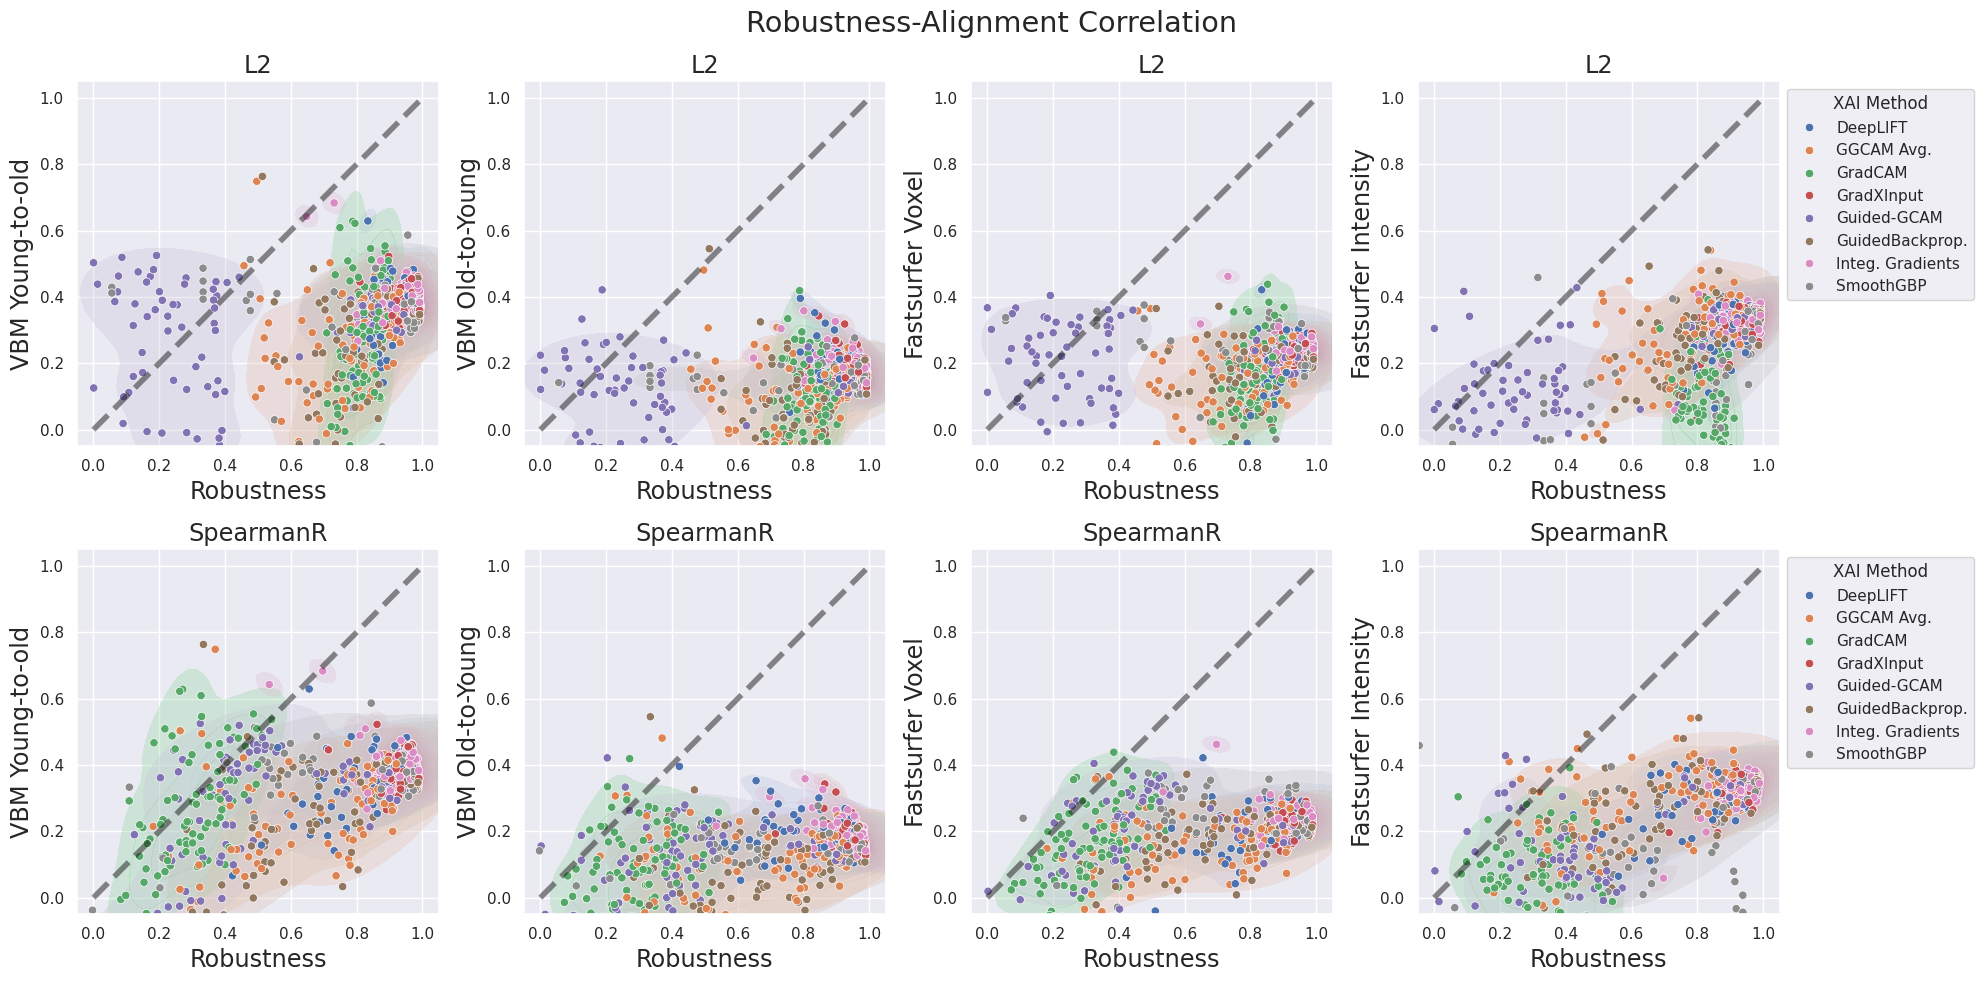

In [38]:
rob_l2 = robustness[(robustness["Similarity Method"] == "L2")]
rob_sr = robustness[(robustness["Similarity Method"] == "SpearmanR")]

fig, ax = plt.subplots(figsize=(20, 10), ncols=4, nrows=2)

for idx, metakey in enumerate(metadata):
    ali = alignment[alignment["Similarity Method"] == metakey]
    show_legend = idx == (len(metadata) - 1)
    plot_corr(x=rob_l2, x_col="Robustness", y=ali, y_col=metakey, show_legend=show_legend, plot_identity=True,
              title="L2", ax=ax[0, idx])
    plot_corr(x=rob_sr, x_col="Robustness", y=ali, y_col=metakey, show_legend=show_legend, plot_identity=True,
              title="SpearmanR", ax=ax[1, idx])
fig.suptitle("Robustness-Alignment Correlation", size="xx-large")
fig.tight_layout()

### Consensus/Robustness vs. ML-Perf.

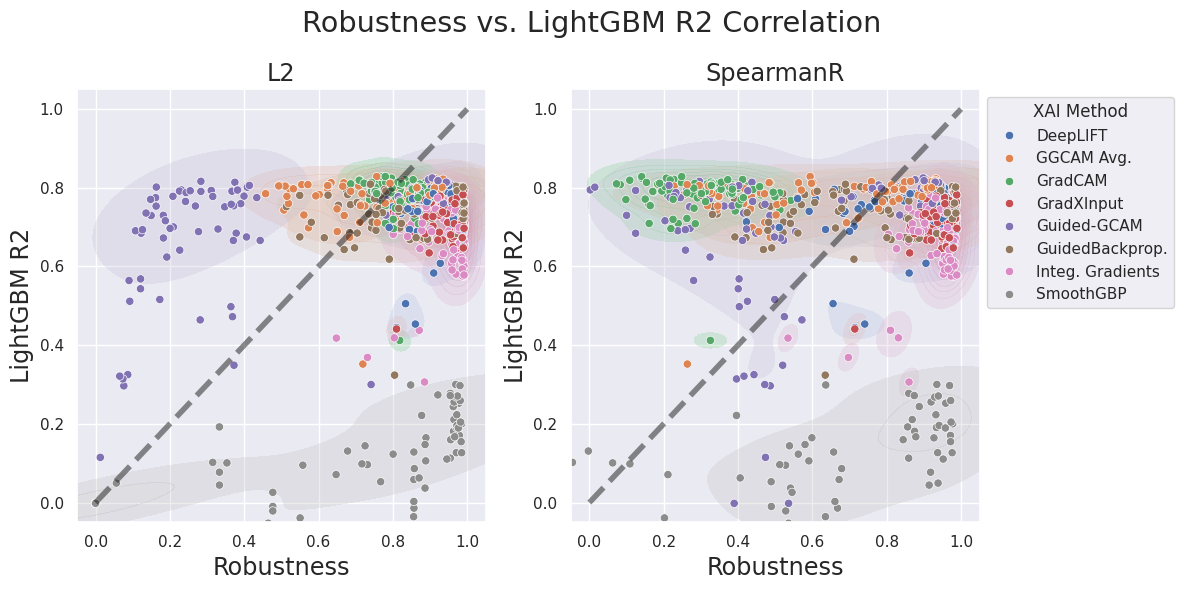

In [39]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

perf = age_lgbm[["r2", "XAI Method", "Model Key"]]
perf.columns = ["Similarity"] + PIVOT_COLS

rob = robustness[(robustness["Similarity Method"] == "L2")]
plot_corr(x=rob, x_col="Robustness", y=perf, y_col="LightGBM R2", show_legend=False, plot_identity=True,
          title="L2", ax=ax[0])


rob = robustness[(robustness["Similarity Method"] == "SpearmanR")]
plot_corr(x=rob, x_col="Robustness", y=perf, y_col="LightGBM R2", show_legend=True, plot_identity=True,
          title="SpearmanR", ax=ax[1])

fig.suptitle("Robustness vs. LightGBM R2 Correlation", size="xx-large")
fig.tight_layout()

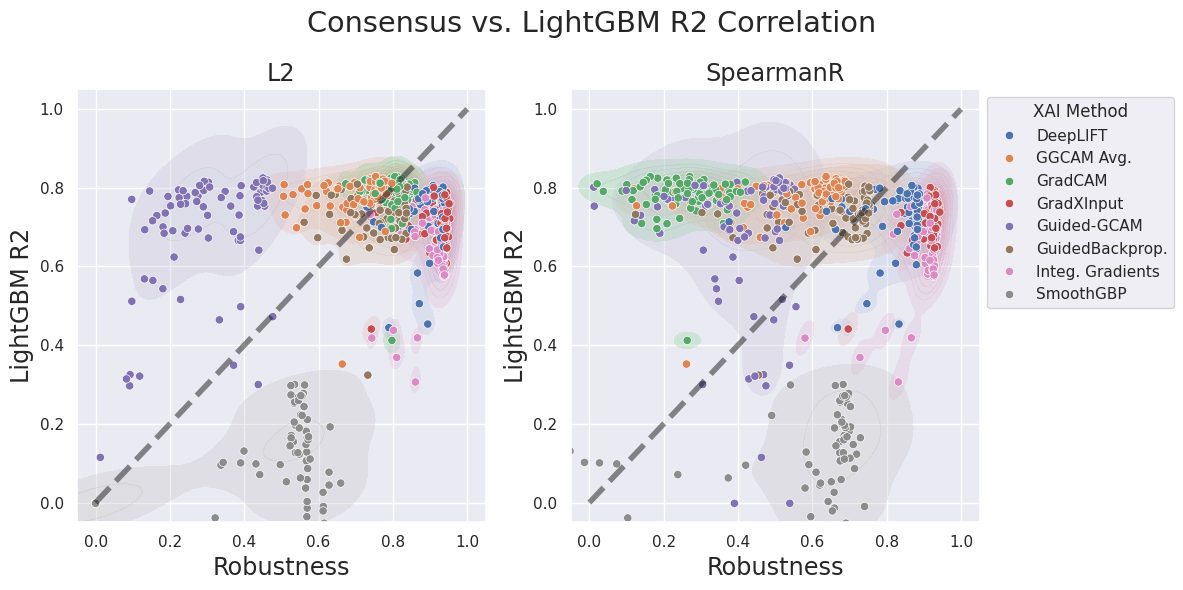

In [40]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

perf = age_lgbm[["r2", "XAI Method", "Model Key"]]
perf.columns = ["Similarity"] + PIVOT_COLS

con = consensus[(consensus["Similarity Method"] == "L2")]
plot_corr(x=con, x_col="Robustness", y=perf, y_col="LightGBM R2", show_legend=False, plot_identity=True,
          title="L2", ax=ax[0])


con = consensus[(consensus["Similarity Method"] == "SpearmanR")]
plot_corr(x=con, x_col="Robustness", y=perf, y_col="LightGBM R2", show_legend=True, plot_identity=True,
          title="SpearmanR", ax=ax[1])

fig.suptitle("Consensus vs. LightGBM R2 Correlation", size="xx-large")
fig.tight_layout()

### Alignments vs. LightGBM Perf

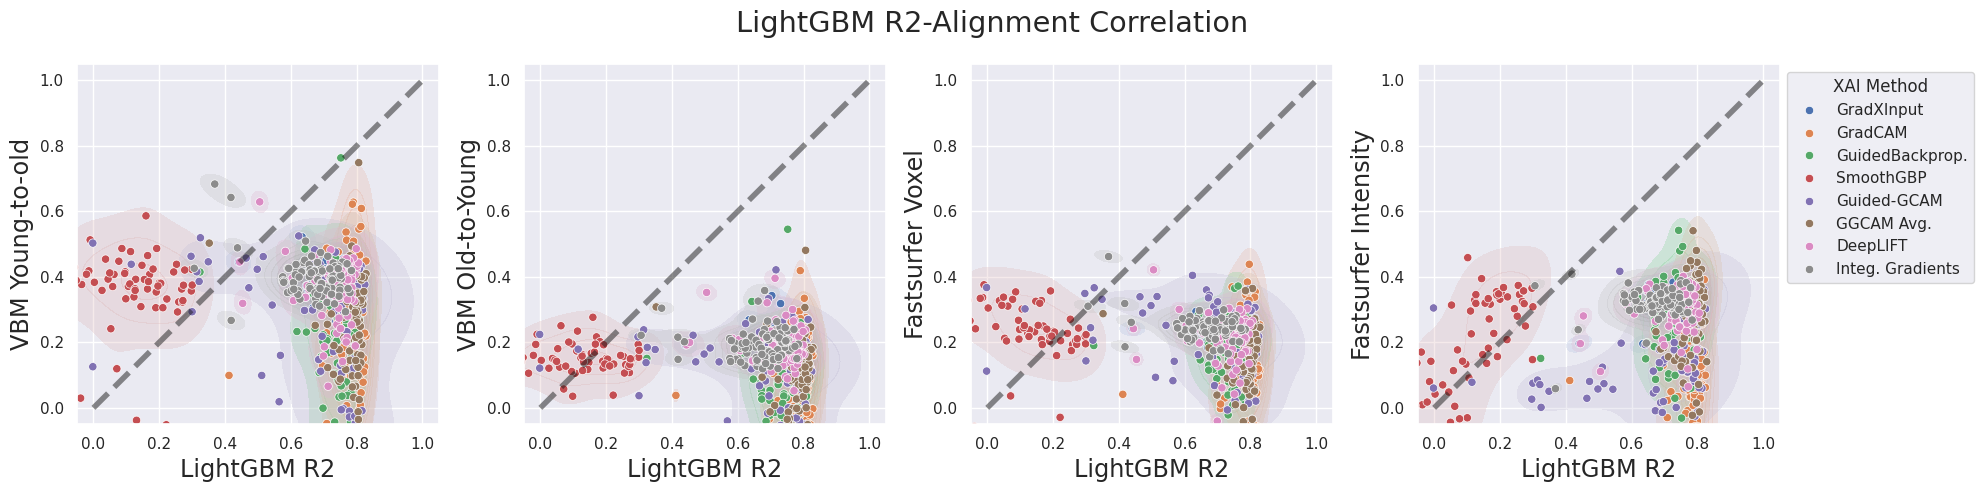

In [41]:
fig, ax = plt.subplots(figsize=(20, 5), ncols=4)

perf = age_lgbm[["r2", "XAI Method", "Model Key"]]
perf.columns = ["Similarity"] + PIVOT_COLS
for idx, metakey in enumerate(metadata):
    ali = alignment[alignment["Similarity Method"] == metakey]
    plot_corr(x=perf, x_col="LightGBM R2", y=ali, y_col=metakey, show_legend=idx == (len(metadata) - 1),
              plot_identity=True, title="", ax=ax[idx])
fig.suptitle("LightGBM R2-Alignment Correlation", size="xx-large")
fig.tight_layout()

## Alignment Plot 다시 그리기

In [10]:
from typing import List
from pathlib import Path

import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

from metadata import load_fastsurfer, load_fastsurfer_adni, load_interps, _open_pkl
import constants as C

ASSETS_DIR = Path(".").absolute() / "assets"
ukb_xai = _open_pkl(ASSETS_DIR / "ukb_xai.pkl")
adni_xai = _open_pkl(ASSETS_DIR / "adni_xai.pkl")

```python
ukb_xai = load_interps(load_indiv=False)
adni_xai = load_interps(load_indiv=False, base_dir=C.ADNI_WEIGHT_DIR, is_cls=True)
```

In [32]:
STAT_THD = 0.05 / len(C.ROI_COLUMNS)
def sort_dict(dct: dict, use_above_thd: bool = True) -> List[str]:
    """Each dictionary contains
    key: [ stats, pval ]
    
    Return list of keys, sorted by stats, descending order
    (highest correlated roi goes to first)
    """
    if use_above_thd:
        dct = {k: v for k, v in dct.items() if v[1] < STAT_THD}
    dct = sorted(dct.items(), key=(lambda x: abs(x[1][0])), reverse=True)
    return [d[0] for d in dct]


def return_rank(dct: dict) -> List[str]:
    """Each dictionary contains
    key: [ stats, pval ]
    
    Return list of keys, sorted by stats, descending order
    (highest correlated roi goes to first)
    """
    dct = sorted(dct.items(), key=(lambda x: abs(x[1][0])), reverse=True)
    return [d[0] for d in dct]

In [33]:
# Prepare sorted region of interests
ukb_fs = load_fastsurfer()
ukb_fs_v = ukb_fs["fastsurfer_volume_dict"]
ukb_fs_v_l = sort_dict(ukb_fs_v)
ukb_fs_i = ukb_fs["fastsurfer_intensity_dict"]
ukb_fs_i_l = sort_dict(ukb_fs_i)

adni_fs = load_fastsurfer_adni()
adni_fs_v = adni_fs["fastsurfer_volume_ttest_dict"]
adni_fs_v_l = sort_dict(adni_fs_v)
adni_fs_i = adni_fs["fastsurfer_intensity_ttest_dict"]
adni_fs_i_l = sort_dict(adni_fs_i)

Flat to one...

1. model-seed 별로 metric 구하고 평균 -> as representative value (이게 이미 계산되어 있는 값)
2. plot은 어떻게 그리는게맞지 -> rank 평균구해서 deviation이랑 같이표기

```
`ukb_xai`: {     
xai_method: {     
    model: [     
        {roi: val, ...},     
        ... seeds     
    ],     
    ...      
}}```

In [34]:
def sort_method_roi(dct: dict, gt: List[str], normalize: bool = True) -> List[int]:
    """For a given input `dct`, rank each RoI,
    and then return a list of ranks sorted in the order of GT
    This applies to a method of single model's single seed
    """
    keys = list(dct.keys())
    order = np.argsort(list(dct.values()))
    num_roi = len(order)
    sorted_model = {keys[v]: num_roi - i for i, v in enumerate(order)}
    plot_order = [sorted_model[roi] for roi in gt]
    if normalize:
        plot_order = [r / num_roi for r in plot_order]
    return plot_order

In [43]:
from scipy.stats import linregress

In [75]:
def get_rank_df(xai: dict, gt: List[str], normalize: bool = True) -> pd.DataFrame:
    ground_truth = [idx for idx, _ in enumerate(gt)]

    sorted_xai_dict = []
    for xai_method in xai.keys():
        models_xai = []
        for model in xai[xai_method]:
            models: List[dict] = xai[xai_method][model]
            sorted_xai = np.array([
                sort_method_roi(dct=dct, gt=gt, normalize=normalize) for dct in models
            ]).mean(axis=0)
            models_xai.append(sorted_xai)
        models_xai = np.array(models_xai).mean(axis=0)
        sorted_xai_dict.append(pd.DataFrame({
            "Ground Truth": ground_truth,
            "Predicted Rank": models_xai,
            "Method": [xai_method] * len(models_xai)
        }))
        
    df = pd.concat(sorted_xai_dict)
    df = df.replace(to_replace=C.XAI_METHODS_MAPPER)
    return df


def plot_rank(df: pd.DataFrame, gt: List[str],
              normalize: bool = True, title: str = "",
              ax=None, plot_legend: bool = True,):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
        
    if normalize:
        m = df.Method.sample(1).iloc[0]
        max_rank = float((df.Method == m).sum())
        df["Ground Truth"] = pd.to_numeric(df["Ground Truth"], errors="coerce") / max_rank

    sns.scatterplot(data=df, x="Ground Truth", y="Predicted Rank",
                    hue="Method", style="Method", hue_order=list(C.XAI_METHODS_MAPPER.values()),
                    s=40, alpha=0.6, ax=ax)
    for xai_method in C.XAI_METHODS_MAPPER.values():
        sns.regplot(data=df[df.Method == xai_method], x="Ground Truth", y="Predicted Rank",
                    scatter=False, line_kws={"linewidth": 3}, ax=ax)

    sns.lineplot(x=np.linspace(0, 1 if normalize else len(gt)),
                 y=np.linspace(0, 1 if normalize else len(gt)),
                 color="k", alpha=0.5, linewidth=4, linestyle="--", ax=ax)

    t = "Normalized Percentile " if normalize else ""
    ax.set_xlabel(f"Ground Truth {t}Rank")
    ax.set_ylabel(f"Predicted {t} Rank")
    ax.set_title(title, size="large")
    if plot_legend:
        ax.legend(bbox_to_anchor=(1., 1.05))
    else:
        ax.legend().remove()
    return ax

In [76]:
normalize = True

In [77]:
rank = get_rank_df(xai=ukb_xai, gt=ukb_fs_v_l, normalize=normalize)
rank_dict = {}
for method in rank.Method.unique():
    subrank = rank[rank.Method == method]
    reg = linregress(x=subrank["Ground Truth"], y=subrank["Predicted Rank"])
    txt = f"{method:20s}: {reg.slope:.6f}, pval={reg.pvalue:.4f}"
    rank_dict[method] = (txt, reg.slope)

rank_dict = sorted(rank_dict.items(), key=lambda x: x[1][1], reverse=True)
print("UKB Rank Order")
for _, t in rank_dict:
    print(t[0])

UKB Rank Order
GradXInput          : 0.003116, pval=0.0039
DeepLIFT            : 0.003036, pval=0.0030
Integ. Gradients    : 0.002973, pval=0.0054
GuidedBackprop.     : 0.002836, pval=0.0015
GGCAM Avg.          : 0.002743, pval=0.0008
SmoothGrad          : 0.002685, pval=0.0000
SmoothGBP           : 0.002402, pval=0.0000
Guided-GCAM         : 0.001791, pval=0.0007
GradCAM             : 0.001691, pval=0.0003


In [78]:
rank = get_rank_df(xai=adni_xai, gt=adni_fs_v_l, normalize=normalize)
rank_dict = {}
for method in rank.Method.unique():
    subrank = rank[rank.Method == method]
    reg = linregress(x=subrank["Ground Truth"], y=subrank["Predicted Rank"])
    txt = f"{method:20s}: {reg.slope:.4f}, pval={reg.pvalue:.4f}"
    rank_dict[method] = (txt, reg.slope)

rank_dict = sorted(rank_dict.items(), key=lambda x: x[1][1], reverse=True)
print("ADNI Rank Order")
for _, t in rank_dict:
    print(t[0])

ADNI Rank Order
GradXInput          : 0.0177, pval=0.0001
Integ. Gradients    : 0.0172, pval=0.0001
DeepLIFT            : 0.0165, pval=0.0001
GuidedBackprop.     : 0.0120, pval=0.0010
SmoothGrad          : 0.0095, pval=0.0024
GGCAM Avg.          : 0.0084, pval=0.0038
Guided-GCAM         : 0.0068, pval=0.0204
SmoothGBP           : 0.0066, pval=0.0100
GradCAM             : 0.0019, pval=0.4047


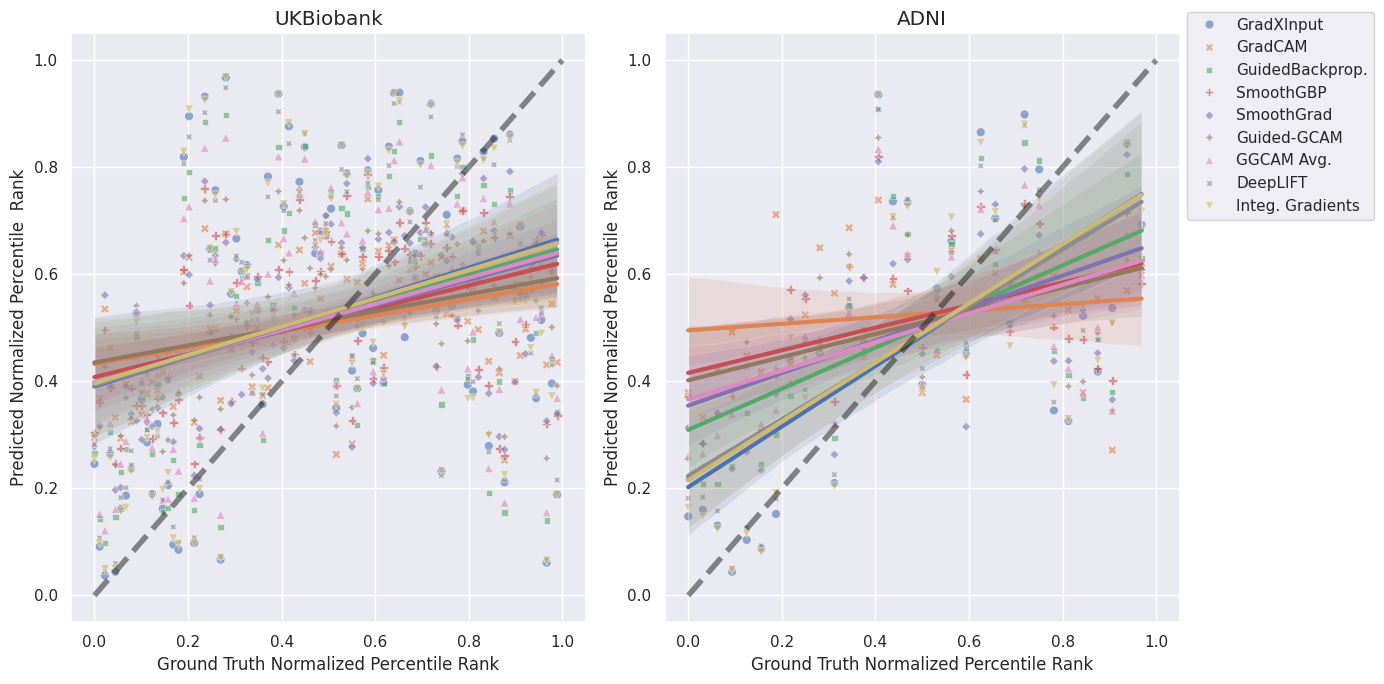

In [79]:
# Intensity
fig, ax = plt.subplots(figsize=(14, 7), ncols=2)
plot_rank(df=get_rank_df(xai=ukb_xai, gt=ukb_fs_v_l, normalize=normalize),
          gt=ukb_fs_v_l, normalize=normalize, ax=ax[0], title="UKBiobank", plot_legend=False)

plot_rank(df=get_rank_df(xai=adni_xai, gt=adni_fs_v_l, normalize=normalize),
          gt=adni_fs_v_l, normalize=normalize, ax=ax[1], title="ADNI")
fig.tight_layout()
fig.savefig(ASSETS_DIR / f"fs_align_volume_norm{normalize}.pdf", format="pdf", dpi=100, bbox_inches='tight')

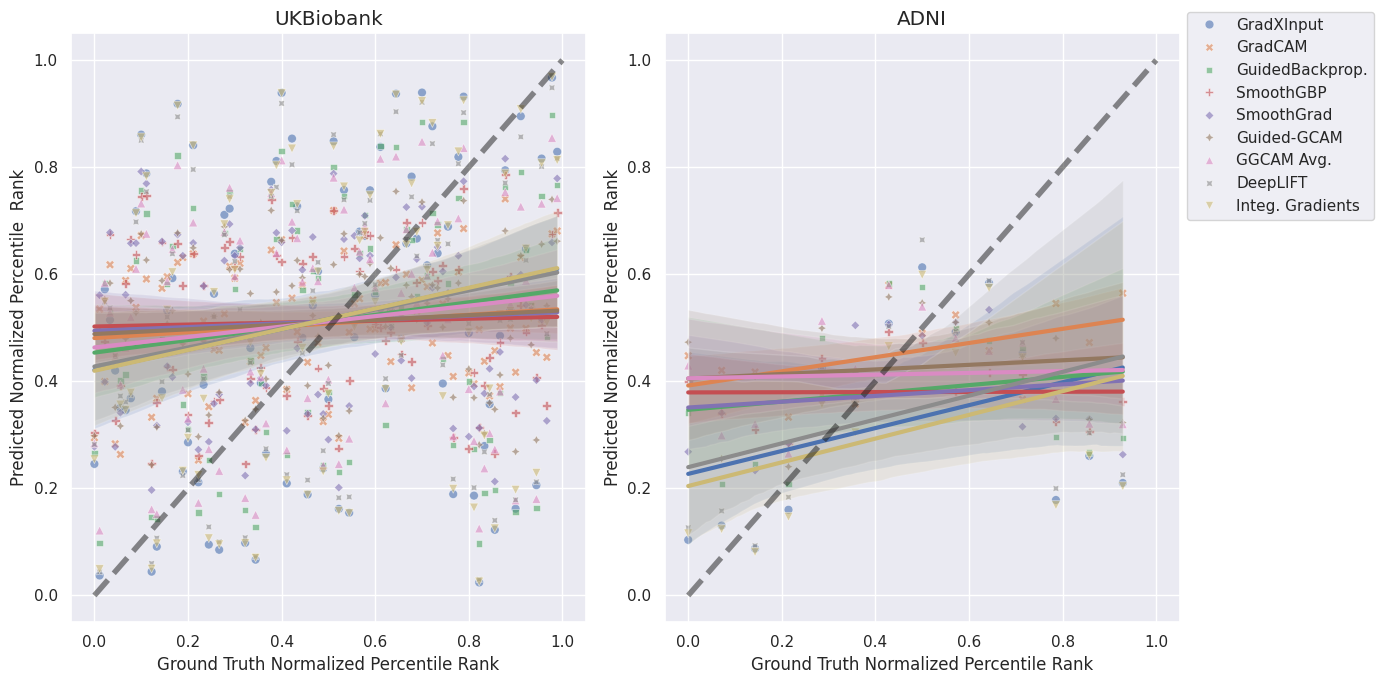

In [80]:
# Intensity
fig, ax = plt.subplots(figsize=(14, 7), ncols=2)
plot_rank(df=get_rank_df(xai=ukb_xai, gt=ukb_fs_i_l, normalize=normalize),
          gt=ukb_fs_i_l, normalize=normalize, ax=ax[0], title="UKBiobank", plot_legend=False)

plot_rank(df=get_rank_df(xai=adni_xai, gt=adni_fs_i_l, normalize=normalize),
          gt=adni_fs_i_l, normalize=normalize, ax=ax[1], title="ADNI",)
fig.tight_layout()
fig.savefig(ASSETS_DIR / f"fs_align_intensity_norm{normalize}.pdf", format="pdf", dpi=100, bbox_inches='tight')